In [1]:
import time
start_time = time.time()

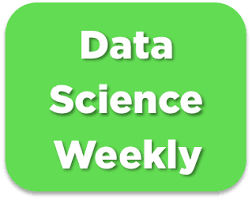

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [2]:
!pip install plotly==5.0.0 -q
!pip install -U scikit-learn -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.


In [3]:
import pandas as pd
import numpy as np

from scipy import stats

# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv, enable_hist_gradient_boosting

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, auc
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, roc_curve, average_precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from plotly.subplots import make_subplots

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [4]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels :', data.shape)

Set with labels : (284580, 6)


In [5]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [6]:
mask = data["converted"] == 1
data_c = data.loc[mask,:]
data_c.describe(include="all")

,country,age,new_user,source,total_pages_visited,converted
count,9180,9180.000000,9180.000000,9180,9180.000000,9180.0
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,6070,NaN,NaN,4585,NaN,NaN
mean,NaN,26.567647,0.298584,NaN,14.560022,1.0
std,NaN,7.085390,0.457662,NaN,3.959594,0.0
min,NaN,17.000000,0.000000,NaN,2.000000,1.0
25%,NaN,21.000000,0.000000,NaN,12.000000,1.0
50%,NaN,25.000000,0.000000,NaN,14.000000,1.0
75%,NaN,31.000000,1.000000,NaN,17.000000,1.0


# Explore dataset

In [7]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)
#data = data.sample(10000)

In [8]:
data_sample.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

<AxesSubplot:xlabel='country', ylabel='count'>

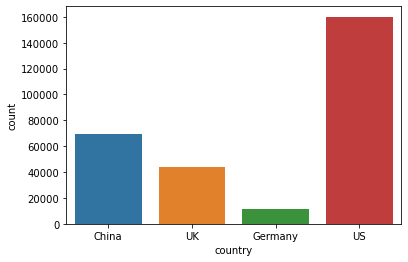

In [9]:
sns.countplot(x=data['country'])

In [10]:
px.histogram(data, x='country')

<AxesSubplot:xlabel='country', ylabel='count'>

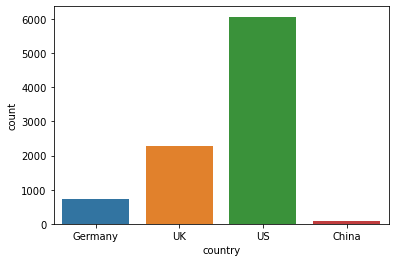

In [11]:
sns.countplot(x=data_c['country'])

<AxesSubplot:xlabel='new_user', ylabel='count'>

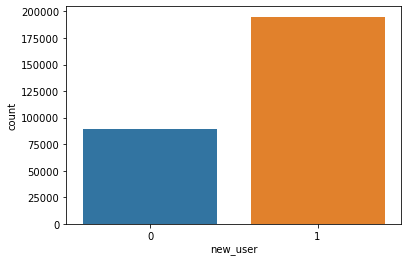

In [12]:
sns.countplot(x=data['new_user'])

<AxesSubplot:xlabel='new_user', ylabel='count'>

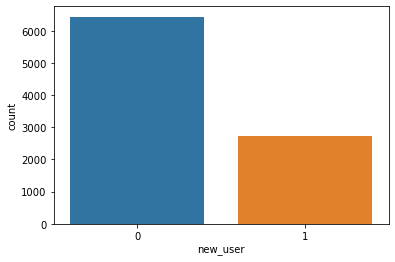

In [13]:
sns.countplot(x=data_c['new_user'])

<AxesSubplot:xlabel='source', ylabel='count'>

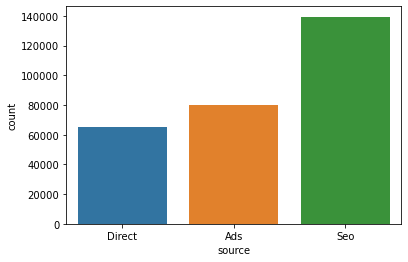

In [14]:
sns.countplot(x=data['source'])

<AxesSubplot:xlabel='source', ylabel='count'>

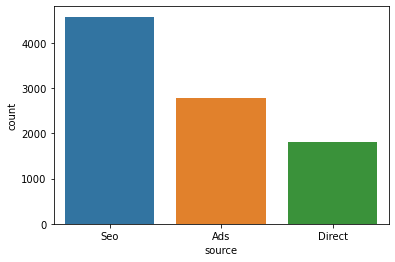

In [15]:
sns.countplot(x=data_c['source'])

<AxesSubplot:xlabel='total_pages_visited'>

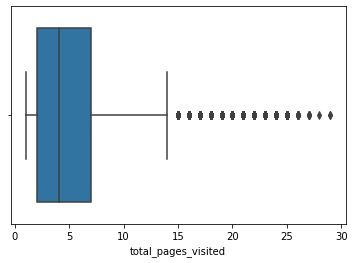

In [16]:
sns.boxplot(x=data["total_pages_visited"])

<AxesSubplot:xlabel='total_pages_visited'>

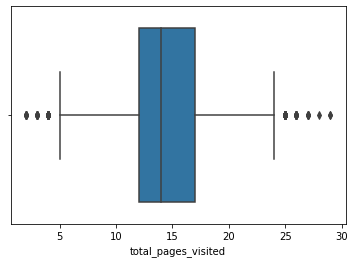

In [17]:
sns.boxplot(x=data_c["total_pages_visited"])

<AxesSubplot:xlabel='age'>

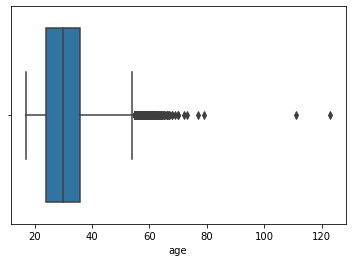

In [18]:
sns.boxplot(x=data["age"])

<AxesSubplot:xlabel='age'>

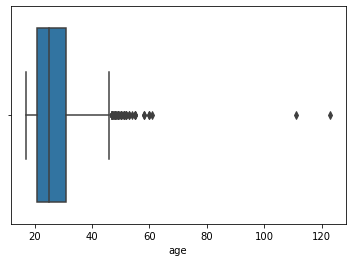

In [19]:
sns.boxplot(x=data_c["age"])

In [20]:
data_sample.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

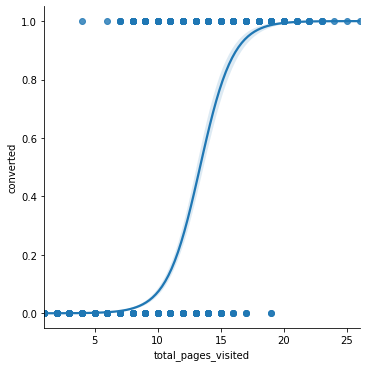

In [21]:
sns.lmplot(x = 'total_pages_visited', y = 'converted', data = data_sample, logistic = True)

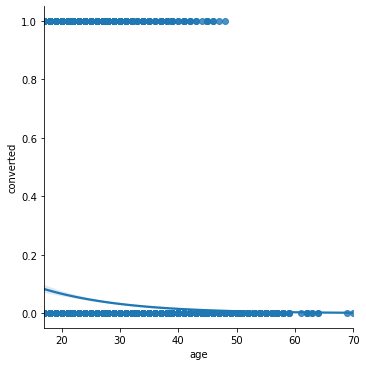

In [22]:
sns.lmplot(x = 'age', y = 'converted', data = data_sample, logistic = True)

In [23]:
# Basic stats
print("Number of rows : {}".format(data.shape[0]))
print()

print("Display of dataset: ")
display(data.head())
print()

print("Basics statistics: ")
data_desc = data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])

Number of rows : 284580

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [24]:
data.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

<AxesSubplot:>

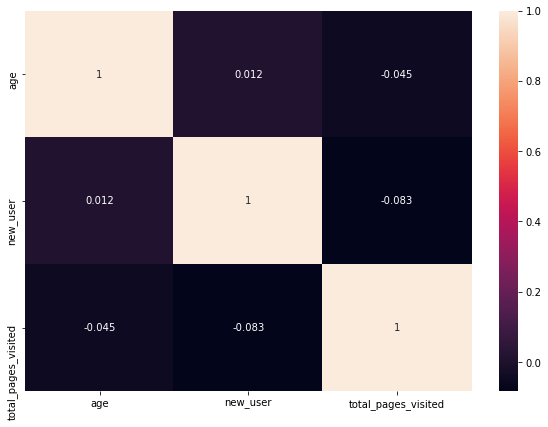

In [110]:
# heat map to check for correlation between the numeric features
plt.figure(figsize= (10,7))
sns.heatmap(data[['age', 'new_user', 'total_pages_visited']].corr(), annot= True)

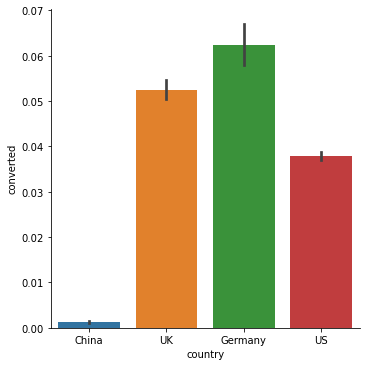

In [25]:
sns.catplot(x="country", y="converted", data=data, kind="bar")

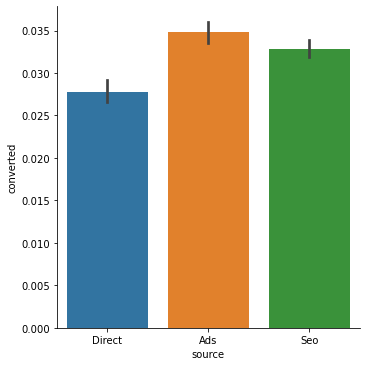

In [26]:
sns.catplot(x="source", y="converted", data=data, kind="bar")

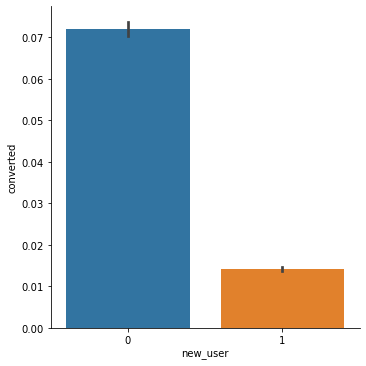

In [27]:
sns.catplot(x="new_user", y="converted", data=data, kind="bar")

In [28]:
mask = data["country"] == "China"

In [29]:
data_china = data.loc[mask,:]

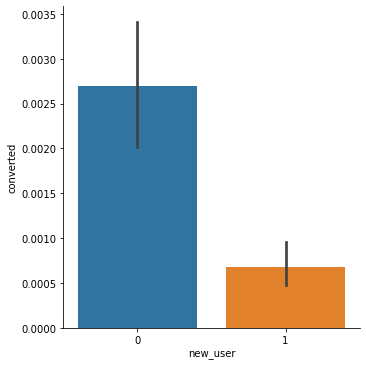

In [30]:
sns.catplot(x="new_user", y="converted", data= data_china, kind="bar")

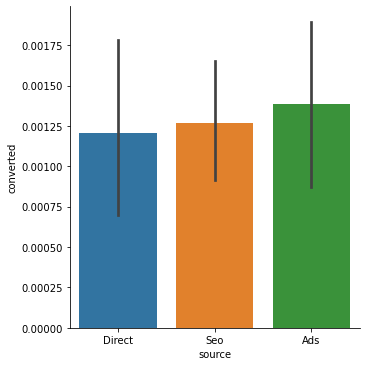

In [31]:
sns.catplot(x="source", y="converted", data= data_china, kind="bar")

<AxesSubplot:xlabel='age'>

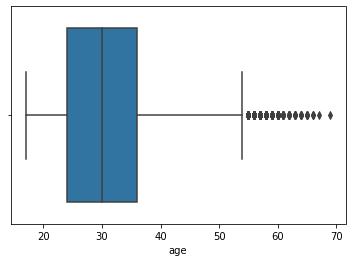

In [32]:
sns.boxplot(x=data_china["age"])

<AxesSubplot:xlabel='total_pages_visited'>

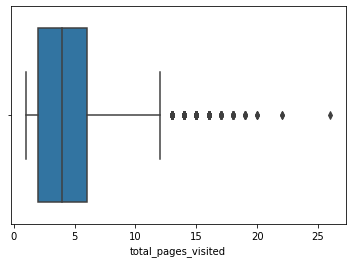

In [33]:
sns.boxplot(x=data_china["total_pages_visited"])

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [34]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [35]:
features_list = ['country', 'age', 'new_user', 'source',"total_pages_visited"]
numeric_features = [1,4]
categorical_features = [0,2]
target_variable = 'converted'

In [36]:
X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [37]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [38]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[['US' 46 0 'Direct' 4]
 ['US' 30 1 'Seo' 7]
 ['China' 34 1 'Ads' 1]
 ['US' 25 1 'Ads' 6]
 ['US' 36 1 'Ads' 1]]
[['China' 25 1 'Seo' 7]
 ['US' 19 1 'Ads' 12]]

[0 0 0 0 0]
[0 1]


In [39]:
np.unique(Y_train)

array([0, 1])

In [40]:
(unique, counts) = np.unique(Y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[     0 192780]
 [     1   6426]]


## Training pipeline

In [41]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
print('...Done.')
print(X_test[0:5,:])
print()




Performing preprocessings on train set...
[['US' 46 0 'Direct' 4]
 ['US' 30 1 'Seo' 7]
 ['China' 34 1 'Ads' 1]
 ['US' 25 1 'Ads' 6]
 ['US' 36 1 'Ads' 1]]
...Done.
[[ 1.86335862 -0.26235872  0.          0.          1.          0.        ]
 [-0.07028352  0.63563837  0.          0.          1.          1.        ]
 [ 0.41312702 -1.1603558   0.          0.          0.          1.        ]
 [-0.67454668  0.33630601  0.          0.          1.          1.        ]
 [ 0.65483228 -1.1603558   0.          0.          1.          1.        ]]

Performing preprocessings on test set...
[['China' 25 1 'Seo' 7]
 ['US' 19 1 'Ads' 12]
 ['US' 34 0 'Ads' 5]
 ['US' 38 0 'Seo' 7]
 ['US' 23 1 'Seo' 9]]
...Done.
[[-0.67454668  0.63563837  0.          0.          0.          1.        ]
 [-1.39966248  2.13230018  0.          0.          1.          1.        ]
 [ 0.41312702  0.03697365  0.          0.          1.          0.        ]
 [ 0.89653755  0.63563837  0.          0.          1.          0.        ]


In [42]:
# replace missing values (here no missing values)
imputer = KNNImputer()

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [43]:
# Train model
print("Train LogisticRegression model...")
classifier = LogisticRegression()  
%time classifier.fit(X_train, Y_train)
print("...Done.")

print("Train DecisionTree model...")
dtc = DecisionTreeClassifier() 
%time dtc.fit(X_train, Y_train)
print("...Done.")

print("Train RandomForestClassifier model...")
rfc = RandomForestClassifier()  
%time rfc.fit(X_train, Y_train)
print("...Done.")

print("Train SVM model...")
svm = SVC()
%time svm.fit(X_train, Y_train)
print("...Done.")



Train LogisticRegression model...
CPU times: user 689 ms, sys: 1.58 s, total: 2.27 s
Wall time: 564 ms
...Done.
Train DecisionTree model...
CPU times: user 197 ms, sys: 503 ms, total: 701 ms
Wall time: 137 ms
...Done.
Train RandomForestClassifier model...
CPU times: user 4.96 s, sys: 474 ms, total: 5.43 s
Wall time: 4.94 s
...Done.
Train SVM model...
CPU times: user 4min 3s, sys: 843 ms, total: 4min 3s
Wall time: 4min 4s
...Done.


## Train predictions for the 3 models

In [44]:
# Predictions on training set with LogisticRegression model
print("Predictions on training set with LogisticRegression model...")
%time Y_train_pred_classifier = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred_classifier)
print()

# Predictions on training set with DecisionTree model
print("Predictions on training set with DecisionTree model...")
%time Y_train_pred_dtc = dtc.predict(X_train)
print("...Done.")
print(Y_train_pred_dtc)
print()

# Predictions on training set with RandomForestClassifier model
print("Predictions on training set with RandomForestClassifier model...")
%time Y_train_pred_rfc = rfc.predict(X_train)
print("...Done.")
print(Y_train_pred_rfc)
print()

# Predictions on training set with SVM model
print("Predictions on training set with SVM model...")
%time Y_train_pred_svm = svm.predict(X_train)
print("...Done.")
print(Y_train_pred_svm)
print()

Predictions on training set with LogisticRegression model...
CPU times: user 2.42 ms, sys: 2.14 ms, total: 4.57 ms
Wall time: 1.34 ms
...Done.
[0 0 0 ... 0 0 0]

Predictions on training set with DecisionTree model...
CPU times: user 22.6 ms, sys: 52.5 ms, total: 75.1 ms
Wall time: 15.4 ms
...Done.
[0 0 0 ... 0 0 0]

Predictions on training set with RandomForestClassifier model...
CPU times: user 1.66 s, sys: 915 ms, total: 2.57 s
Wall time: 1.54 s
...Done.
[0 0 0 ... 0 0 0]

Predictions on training set with SVM model...
CPU times: user 2min 17s, sys: 299 ms, total: 2min 17s
Wall time: 2min 17s
...Done.
[0 0 0 ... 0 0 0]



## Test predictions for the 3 models

In [45]:
# Predictions on testing set with LogisticRegression model
print("Predictions on testing set with LogisticRegression model...")
%time Y_test_pred_classifier = classifier.predict(X_test)
print("...Done.")
print()

# Predictions on testing set with DecisionTree model
print("Predictions on testing set with DecisionTree model...")
%time Y_test_pred_dtc = dtc.predict(X_test)
print("...Done.")
print(Y_test_pred_dtc)
print()

# Predictions on testing set with RandomForestClassifier model
print("Predictions on testing set with RandomForestClassifier model...")
%time Y_test_pred_rfc = rfc.predict(X_test)
print("...Done.")
print()

# Predictions on testing set with SVM model
print("Predictions on testing set with SVM model...")
%time Y_test_pred_svm = svm.predict(X_test)
print("...Done.")
print()

Predictions on testing set with LogisticRegression model...
CPU times: user 1.23 ms, sys: 1.52 ms, total: 2.75 ms
Wall time: 925 µs
...Done.

Predictions on testing set with DecisionTree model...
CPU times: user 8.48 ms, sys: 14.2 ms, total: 22.7 ms
Wall time: 6.42 ms
...Done.
[0 0 0 ... 0 0 0]

Predictions on testing set with RandomForestClassifier model...
CPU times: user 799 ms, sys: 978 ms, total: 1.78 s
Wall time: 658 ms
...Done.

Predictions on testing set with SVM model...
CPU times: user 58.3 s, sys: 67.8 ms, total: 58.4 s
Wall time: 58.4 s
...Done.



## Performance assessment

In [46]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set for LogisticRegression : ", f1_score(Y_train, Y_train_pred_classifier))
print("f1-score on test set for LogisticRegression: ", f1_score(Y_test, Y_test_pred_classifier))
print("f1-score on train set for DecisionTreeClassifier : ", f1_score(Y_train, Y_train_pred_dtc))
print("f1-score on test set for DEcisionTreeClassifier: ", f1_score(Y_test, Y_test_pred_dtc))
print("f1-score on train set for RandomForestClassifier : ", f1_score(Y_train, Y_train_pred_rfc))
print("f1-score on test set for RandomForestClassifier: ", f1_score(Y_test, Y_test_pred_rfc))
print("f1-score on train set for SVM : ", f1_score(Y_train, Y_train_pred_svm))
print("f1-score on test set for SVM: ", f1_score(Y_test, Y_test_pred_svm))

f1-score on train set for LogisticRegression :  0.7646602944975459
f1-score on test set for LogisticRegression:  0.7590216519647153
f1-score on train set for DecisionTreeClassifier :  0.7843103448275862
f1-score on test set for DEcisionTreeClassifier:  0.7361616161616161
f1-score on train set for RandomForestClassifier :  0.7867734787796148
f1-score on test set for RandomForestClassifier:  0.741389607804101
f1-score on train set for SVM :  0.7557758696999203
f1-score on test set for SVM:  0.7484082973916615


In [47]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set for LogisticRegression: ")
print(confusion_matrix(Y_train, Y_train_pred_classifier))
print()
print("Confusion matrix on test set for LogisticRegression: ")
print(confusion_matrix(Y_test, Y_test_pred_classifier))
print()
print("Confusion matrix on train set for DecisionTreeClassifier: ")
print(confusion_matrix(Y_train, Y_train_pred_dtc))
print()
print("Confusion matrix on test set for DecisionTreeClassifier: ")
print(confusion_matrix(Y_test, Y_test_pred_dtc))
print()
print("Confusion matrix on train set for RandomForestClassifier: ")
print(confusion_matrix(Y_train, Y_train_pred_rfc))
print()
print("Confusion matrix on test set for RandomForestClassifier: ")
print(confusion_matrix(Y_test, Y_test_pred_rfc))
print()
print("Confusion matrix on train set for SVM: ")
print(confusion_matrix(Y_train, Y_train_pred_svm))
print()
print("Confusion matrix on test set for SVM: ")
print(confusion_matrix(Y_test, Y_test_pred_svm))
print()

Confusion matrix on train set for LogisticRegression: 
[[192033    747]
 [  1986   4440]]

Confusion matrix on test set for LogisticRegression: 
[[82279   341]
 [  861  1893]]

Confusion matrix on train set for DecisionTreeClassifier: 
[[192155    625]
 [  1877   4549]]

Confusion matrix on test set for DecisionTreeClassifier: 
[[82246   374]
 [  932  1822]]

Confusion matrix on train set for RandomForestClassifier: 
[[192088    692]
 [  1810   4616]]

Confusion matrix on test set for RandomForestClassifier: 
[[82213   407]
 [  892  1862]]

Confusion matrix on train set for SVM: 
[[192178    602]
 [  2157   4269]]

Confusion matrix on test set for SVM: 
[[82327   293]
 [  932  1822]]



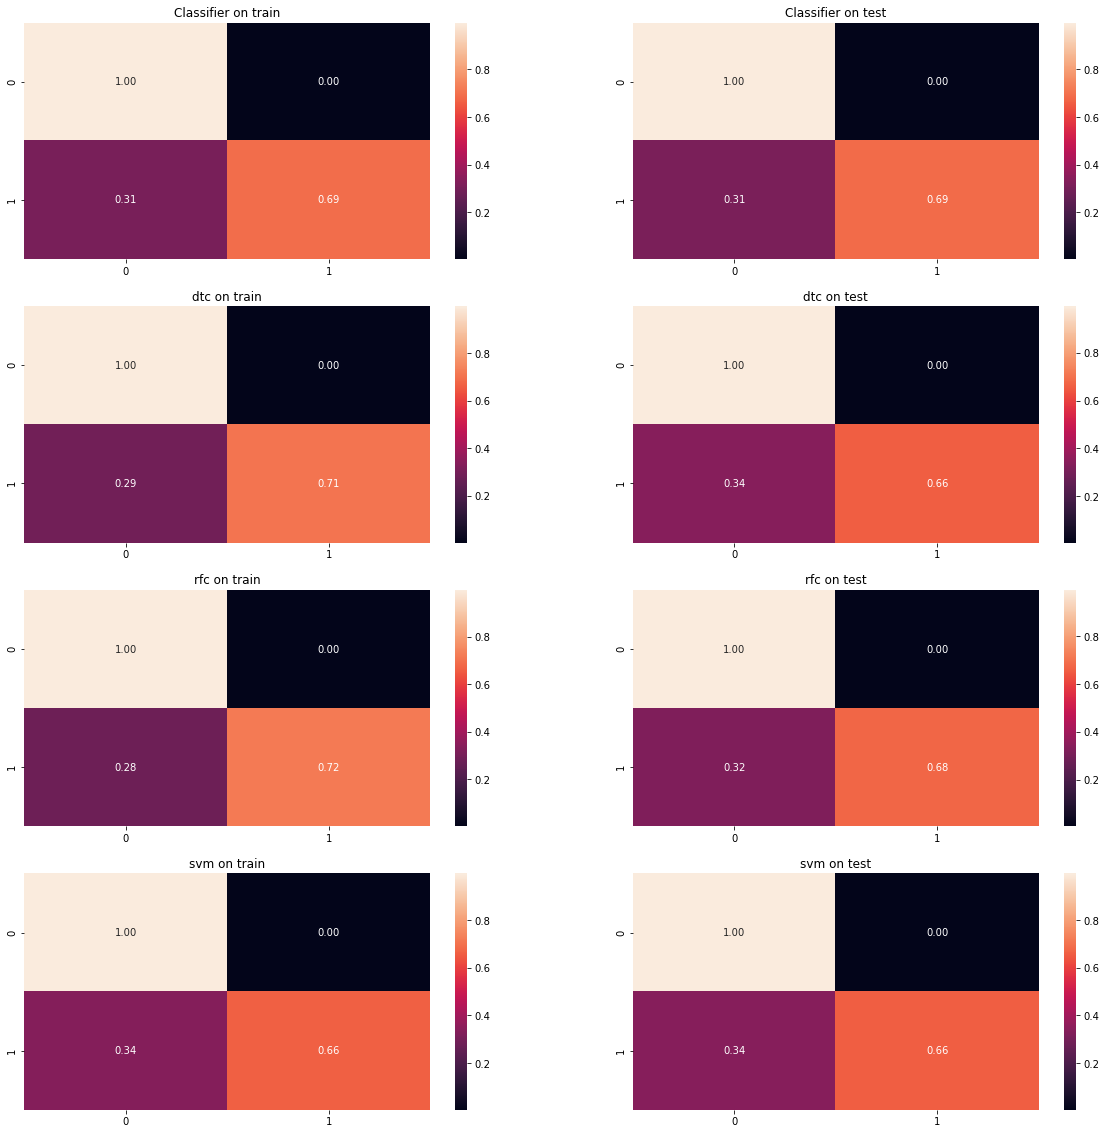

In [48]:
fig, axs = plt.subplots(4, 2, figsize=(20, 20))


cm = confusion_matrix(Y_train, Y_train_pred_classifier, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", ax=axs[0, 0])
axs[0, 0].set_title("Classifier on train")

cm2 = confusion_matrix(Y_test, Y_test_pred_classifier, normalize="true")
sns.heatmap(cm2, annot=True, fmt=".2f", ax=axs[0, 1])
axs[0, 1].set_title("Classifier on test")

cm3 = confusion_matrix(Y_train, Y_train_pred_dtc, normalize="true")
sns.heatmap(cm3, annot=True, fmt=".2f", ax=axs[1, 0])
axs[1, 0].set_title("dtc on train")

cm4 = confusion_matrix(Y_test, Y_test_pred_dtc, normalize="true")
sns.heatmap(cm4, annot=True, fmt=".2f", ax=axs[1, 1])
axs[1, 1].set_title("dtc on test")

cm5 = confusion_matrix(Y_train, Y_train_pred_rfc, normalize="true")
sns.heatmap(cm5, annot=True, fmt=".2f", ax=axs[2, 0])
axs[2, 0].set_title("rfc on train")

cm6 = confusion_matrix(Y_test, Y_test_pred_rfc, normalize="true")
sns.heatmap(cm6, annot=True, fmt=".2f", ax=axs[2, 1])
axs[2, 1].set_title("rfc on test")

cm7 = confusion_matrix(Y_train, Y_train_pred_svm, normalize="true")
sns.heatmap(cm7, annot=True, fmt=".2f", ax=axs[3, 0])
axs[3, 0].set_title("svm on train")

cm8 = confusion_matrix(Y_test, Y_test_pred_svm, normalize="true")
sns.heatmap(cm8, annot=True, fmt=".2f", ax=axs[3, 1])
axs[3, 1].set_title("svm on test")

plt.show()

## Instantiation of the models with optimisation of parameters: Grid Search

In [106]:
# Instantiation of the models
classifier = LogisticRegression()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()


param_grid_logClass = {"C":np.logspace(-3,3,7)}

grid_logClass = HalvingGridSearchCV(classifier, param_grid=param_grid_logClass, cv=10, 
                             verbose=2, n_jobs=-1, return_train_score=True, scoring='f1')
print(grid_logClass)


param_grid_dtc = {"max_depth":np.arange(3,20,2),
                 "criterion" : ["gini", "entropy"],
                 "min_samples_split": np.arange(2,9,2),
                 "min_samples_leaf":np.arange(1,10,2),
                  "class_weight":["balanced",None]
                }

grid_dtc = HalvingGridSearchCV(dtc, param_grid=param_grid_dtc, 
                        cv=10, verbose=2, n_jobs=-1, 
                        return_train_score=True, scoring='f1')
print(grid_dtc)


param_grid_rfc = {"n_estimators": np.arange(20,141,40),
                 "max_depth": np.arange(3,20,4),
                 "criterion" : ["gini", "entropy"],
                 'min_samples_split': np.arange(2,9,2),
                 "min_samples_leaf": np.arange(1,10,2),
                  "class_weight": ["balanced", "balanced_subsample",None]
                }

grid_rfc = HalvingGridSearchCV(rfc, param_grid=param_grid_rfc, 
                cv=10, verbose=2, n_jobs=-1, 
                return_train_score=True, scoring='f1')
print(grid_rfc)

param_grid_svm = {"kernel":["poly"],
                  "C":[10.0**i for i in np.arange(-5,-1,1)],
                  "gamma": [10.0**i for i in np.arange(-1,3,1)]}

grid_svm = GridSearchCV(svc, param_grid=param_grid_svm, cv=10,
                               verbose=2, n_jobs=-1, return_train_score=True, scoring='f1')
print(grid_svm)

HalvingGridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
                    param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
                    refit=<function _refit_callable at 0x7ffd9061e820>,
                    scoring='f1', verbose=2)
HalvingGridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
                    param_grid={'class_weight': ['balanced', None],
                                'criterion': ['gini', 'entropy'],
                                'max_depth': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                'min_samples_leaf': array([1, 3, 5, 7, 9]),
                                'min_samples_split': array([2, 4, 6, 8])},
                    refit=<function _refit_callable at 0x7ffd9061e820>,
                    scoring='f1', verbose=2)
HalvingGridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
                    param_grid={'class_weight': ['balanced',
         

NameError: name 'svc' is not defined

In [50]:
%time grid_logClass.fit(X_train, Y_train)
%time grid_dtc.fit(X_train, Y_train)
%time grid_rfc.fit(X_train, Y_train)
#for svm we use preoptimates parameters (time of optimisation: very long)
#grid_svm = SVC(kernel="poly", C=0.0001, gamma=10.0)
%time grid_svm.fit(X_train, Y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 66402
max_resources_: 199206
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 7
n_resources: 66402
Fitting 10 folds for each of 7 candidates, totalling 70 fits
----------
iter: 1
n_candidates: 3
n_resources: 199206
Fitting 10 folds for each of 3 candidates, totalling 30 fits
CPU times: user 585 ms, sys: 803 ms, total: 1.39 s
Wall time: 4.38 s
n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 819
max_resources_: 199206
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 720
n_resources: 819
Fitting 10 folds for each of 720 candidates, totalling 7200 fits


/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



----------
iter: 1
n_candidates: 240
n_resources: 2457
Fitting 10 folds for each of 240 candidates, totalling 2400 fits
----------
iter: 2
n_candidates: 80
n_resources: 7371
Fitting 10 folds for each of 80 candidates, totalling 800 fits
----------
iter: 3
n_candidates: 27
n_resources: 22113
Fitting 10 folds for each of 27 candidates, totalling 270 fits
----------
iter: 4
n_candidates: 9
n_resources: 66339
Fitting 10 folds for each of 9 candidates, totalling 90 fits
CPU times: user 3.1 s, sys: 557 ms, total: 3.66 s
Wall time: 8.72 s
n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 91
max_resources_: 199206
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2400
n_resources: 91
Fitting 10 folds for each of 2400 candidates, totalling 24000 fits
----------
iter: 1
n_candidates: 800
n_resources: 273
Fitting 10 folds for each of 800 candidates, totalling 8000 fits
----------
iter: 2
n_candidates: 267
n_resources: 819
Fitting 10 folds for

/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



----------
iter: 6
n_candidates: 4
n_resources: 66339
Fitting 10 folds for each of 4 candidates, totalling 40 fits


/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



----------
iter: 7
n_candidates: 2
n_resources: 199017
Fitting 10 folds for each of 2 candidates, totalling 20 fits


/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CPU times: user 31.2 s, sys: 2.49 s, total: 33.7 s
Wall time: 9min 36s
CPU times: user 3min 2s, sys: 428 ms, total: 3min 2s
Wall time: 3min 2s


SVC(C=0.0001, gamma=10.0, kernel='poly')

In [51]:
print("the best set of parameters for the LogisticRegression is : \n {0} \n the best set of parameters for the Decision Tree is : \n {1} \n the best set of parameters for the random forest is : \n {2}".format(grid_logClass.best_params_, grid_dtc.best_params_, grid_rfc.best_params_))

the best set of parameters for the LogisticRegression is : 
 {'C': 100.0} 
 the best set of parameters for the Decision Tree is : 
 {'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 6} 
 the best set of parameters for the random forest is : 
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


Train scores for LogClass best model are : 
 [0.7674240977658965, 0.7655905738097518, 0.7651160569299837, 0.7672356250595976, 0.7627898064763365, 0.7639115027296237, 0.7626988690818478, 0.7635283976630591, 0.7658923621068731, 0.7649196633511859] 
 Train scores for rf best model are : 
 [0.7555555555555556, 0.7189189189189189, 0.7643678160919541, 0.7765726681127982, 0.748743718592965, 0.7524271844660194, 0.7347931873479319, 0.7488584474885844, 0.7798165137614678, 0.7751937984496123] 
 Train scores for dtc best model are : 
 [0.6666666666666666, 0.888888888888889, 0.888888888888889, 0.7272727272727273, 0.6666666666666667, 0.75, 0.9090909090909091, 0.6, 0.7272727272727272, 0.7499999999999999] 
 Test scores for LogCLass best model are : 
 [0.741652021089631, 0.7608510638297873, 0.7673819742489271, 0.7456140350877194, 0.7817869415807561, 0.7721088435374149, 0.7775862068965518, 0.7834877843302444, 0.7574978577549272, 0.7600700525394045] 
 Test scores for dtc best model are : 
 [0.79999999999

/Users/jd/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/Users/jd/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/Users/jd/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel 

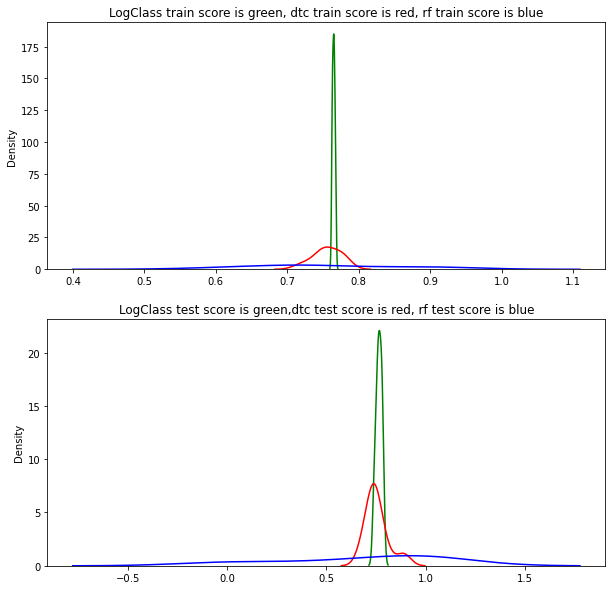

In [52]:
best_logClass_index = np.argmin(grid_logClass.cv_results_["rank_test_score"])

logClass_cv_train_scores = [grid_logClass.cv_results_["split0_train_score"][best_logClass_index],
    grid_logClass.cv_results_["split1_train_score"][best_logClass_index],
    grid_logClass.cv_results_["split2_train_score"][best_logClass_index],
    grid_logClass.cv_results_["split3_train_score"][best_logClass_index],
    grid_logClass.cv_results_["split4_train_score"][best_logClass_index],
    grid_logClass.cv_results_["split5_train_score"][best_logClass_index],
    grid_logClass.cv_results_["split6_train_score"][best_logClass_index],
    grid_logClass.cv_results_["split7_train_score"][best_logClass_index],
    grid_logClass.cv_results_["split8_train_score"][best_logClass_index],
    grid_logClass.cv_results_["split9_train_score"][best_logClass_index]]

logClass_cv_test_scores = [grid_logClass.cv_results_["split0_test_score"][best_logClass_index],
    grid_logClass.cv_results_["split1_test_score"][best_logClass_index],
    grid_logClass.cv_results_["split2_test_score"][best_logClass_index],
    grid_logClass.cv_results_["split3_test_score"][best_logClass_index],
    grid_logClass.cv_results_["split4_test_score"][best_logClass_index],
    grid_logClass.cv_results_["split5_test_score"][best_logClass_index],
    grid_logClass.cv_results_["split6_test_score"][best_logClass_index],
    grid_logClass.cv_results_["split7_test_score"][best_logClass_index],
    grid_logClass.cv_results_["split8_test_score"][best_logClass_index],
    grid_logClass.cv_results_["split9_test_score"][best_logClass_index]]

best_dtc_index = np.argmin(grid_dtc.cv_results_["rank_test_score"])

dtc_cv_train_scores = [grid_dtc.cv_results_["split0_train_score"][best_dtc_index],
    grid_dtc.cv_results_["split1_train_score"][best_dtc_index],
    grid_dtc.cv_results_["split2_train_score"][best_dtc_index],
    grid_dtc.cv_results_["split3_train_score"][best_dtc_index],
    grid_dtc.cv_results_["split4_train_score"][best_dtc_index],
    grid_dtc.cv_results_["split5_train_score"][best_dtc_index],
    grid_dtc.cv_results_["split6_train_score"][best_dtc_index],
    grid_dtc.cv_results_["split7_train_score"][best_dtc_index],
    grid_dtc.cv_results_["split8_train_score"][best_dtc_index],
    grid_dtc.cv_results_["split9_train_score"][best_dtc_index]]

dtc_cv_test_scores = [grid_dtc.cv_results_["split0_test_score"][best_dtc_index],
    grid_dtc.cv_results_["split1_test_score"][best_dtc_index],
    grid_dtc.cv_results_["split2_test_score"][best_dtc_index],
    grid_dtc.cv_results_["split3_test_score"][best_dtc_index],
    grid_dtc.cv_results_["split4_test_score"][best_dtc_index],
    grid_dtc.cv_results_["split5_test_score"][best_dtc_index],
    grid_dtc.cv_results_["split6_test_score"][best_dtc_index],
    grid_dtc.cv_results_["split7_test_score"][best_dtc_index],
    grid_dtc.cv_results_["split8_test_score"][best_dtc_index],
    grid_dtc.cv_results_["split9_test_score"][best_dtc_index]]


best_rf_index = np.argmin(grid_rfc.cv_results_["rank_test_score"])

rf_cv_train_scores = [grid_rfc.cv_results_["split0_train_score"][best_rf_index],
    grid_rfc.cv_results_["split1_train_score"][best_rf_index],
    grid_rfc.cv_results_["split2_train_score"][best_rf_index],
    grid_rfc.cv_results_["split3_train_score"][best_rf_index],
    grid_rfc.cv_results_["split4_train_score"][best_rf_index],
    grid_rfc.cv_results_["split5_train_score"][best_rf_index],
    grid_rfc.cv_results_["split6_train_score"][best_rf_index],
    grid_rfc.cv_results_["split7_train_score"][best_rf_index],
    grid_rfc.cv_results_["split8_train_score"][best_rf_index],
    grid_rfc.cv_results_["split9_train_score"][best_rf_index]]

rf_cv_test_scores = [grid_rfc.cv_results_["split0_test_score"][best_rf_index],
    grid_rfc.cv_results_["split1_test_score"][best_rf_index],
    grid_rfc.cv_results_["split2_test_score"][best_rf_index],
    grid_rfc.cv_results_["split3_test_score"][best_rf_index],
    grid_rfc.cv_results_["split4_test_score"][best_rf_index],
    grid_rfc.cv_results_["split5_test_score"][best_rf_index],
    grid_rfc.cv_results_["split6_test_score"][best_rf_index],
    grid_rfc.cv_results_["split7_test_score"][best_rf_index],
    grid_rfc.cv_results_["split8_test_score"][best_rf_index],
    grid_rfc.cv_results_["split9_test_score"][best_rf_index]]


print("Train scores for LogClass best model are : \n {0} \n Train scores for rf best model are : \n {1} \n Train scores for dtc best model are : \n {2} \n Test scores for LogCLass best model are : \n {3} \n Test scores for dtc best model are : \n {4} \n Test scores for rf best model are : \n {5} ".format(logClass_cv_train_scores,dtc_cv_train_scores,rf_cv_train_scores,logClass_cv_test_scores,dtc_cv_test_scores,rf_cv_test_scores))

fig, ax = plt.subplots(2,1, figsize = (10,10))
sns.distplot(logClass_cv_train_scores, hist=False, color = "green", ax = ax[0])
sns.distplot(dtc_cv_train_scores, hist=False, color = "red", ax = ax[0])
sns.distplot(rf_cv_train_scores, hist=False, color = "blue", ax = ax[0])
ax[0].title.set_text('LogClass train score is green, dtc train score is red, rf train score is blue')

sns.distplot(logClass_cv_test_scores, hist=False, color = "green", ax = ax[1])
sns.distplot(dtc_cv_test_scores, hist=False, color = "red", ax = ax[1])
sns.distplot(rf_cv_test_scores, hist=False, color = "blue", ax = ax[1])
ax[1].title.set_text('LogClass test score is green,dtc test score is red, rf test score is blue')

In [53]:
print("best logistic regression score on the hold out test set : \n {0} \n best dtc score on the hold out test set : \n {1} \n best rf score on the hold out test set : \n {2} \n best svm score on the hold out test set : \n {3}".format(grid_logClass.best_estimator_.score(X_test,Y_test),grid_dtc.best_estimator_.score(X_test,Y_test),grid_rfc.best_estimator_.score(X_test,Y_test), grid_svm.score(X_test,Y_test)))

best logistic regression score on the hold out test set : 
 0.9859324852999742 
 best dtc score on the hold out test set : 
 0.9850071450324455 
 best rf score on the hold out test set : 
 0.9526319488368824 
 best svm score on the hold out test set : 
 0.9855928034296155


In [54]:
# Predictions on training set with LogisticRegression model
grid_logClass = grid_logClass.best_estimator_
print("Predictions on training set with best LogisticRegression model...")
Y_train_pred_grid_logClass = grid_logClass.predict(X_train)
print("...Done.")
print(Y_train_pred_grid_logClass)
print()

# Predictions on training set with DecisionTreeClassifier model
grid_dtc = grid_dtc.best_estimator_
print("Predictions on training set with best DecisionTreeClassifier model...")
Y_train_pred_grid_dtc = grid_dtc.predict(X_train)
print("...Done.")
print(Y_train_pred_grid_dtc)
print()

# Predictions on training set with RandomForestClassifier model
grid_rfc = grid_rfc.best_estimator_
print("Predictions on training set with best RandomForestClassifier model...")
Y_train_pred_grid_rfc = grid_rfc.predict(X_train)
print("...Done.")
print(Y_train_pred_grid_rfc)
print()

# Predictions on training set with SVM model
grid_svm = grid_svm.best_estimator_
print("Predictions on training set with best SVM model...")
Y_train_pred_grid_svm = grid_svm.predict(X_train)
print("...Done.")
print(Y_train_pred_grid_svm)
print()

# Predictions on testing set with LogisticRegression model
print("Predictions on testing set with LogisticRegression model...")
Y_test_pred_grid_logClass = grid_logClass.predict(X_test)
print("...Done.")
print()

# Predictions on testing set with DecisionTreeClassifier model
print("Predictions on testing set with DecisionTreeClassifier model...")
Y_test_pred_grid_dtc = grid_dtc.predict(X_test)
print("...Done.")
print()

# Predictions on testing set with RandomForestClassifier model
print("Predictions on testing set with RandomForestClassifier model...")
Y_test_pred_grid_rfc = grid_rfc.predict(X_test)
print("...Done.")
print()

# Predictions on testing set with SVM model
print("Predictions on testing set with SVM model...")
Y_test_pred_grid_svm = grid_svm.predict(X_test)
print("...Done.")
print()

# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set for best LogisticRegression : ", f1_score(Y_train, Y_train_pred_grid_logClass))
print("f1-score on test set for best LogisticRegression: ", f1_score(Y_test, Y_test_pred_grid_logClass))
print("f1-score on train set for best DecisionTreeClassifier : ", f1_score(Y_train, Y_train_pred_grid_dtc))
print("f1-score on test set for best DecisionTreeClassifier: ", f1_score(Y_test, Y_test_pred_grid_dtc))
print("f1-score on train set for best RandomForestClassifier : ", f1_score(Y_train, Y_train_pred_grid_rfc))
print("f1-score on test set for best RandomForestClassifier: ", f1_score(Y_test, Y_test_pred_grid_rfc))
print("f1-score on train set for best SVM : ", f1_score(Y_train, Y_train_pred_grid_svm))
print("f1-score on test set for best SVM: ", f1_score(Y_test, Y_test_pred_grid_svm))

Predictions on training set with best LogisticRegression model...
...Done.
[0 0 0 ... 0 0 0]

Predictions on training set with best DecisionTreeClassifier model...
...Done.
[0 0 0 ... 0 0 0]

Predictions on training set with best RandomForestClassifier model...
...Done.
[0 0 0 ... 0 1 0]

Predictions on training set with best SVM model...
...Done.
[0 0 0 ... 0 0 0]

Predictions on testing set with LogisticRegression model...
...Done.

Predictions on testing set with DecisionTreeClassifier model...
...Done.

Predictions on testing set with RandomForestClassifier model...
...Done.

Predictions on testing set with SVM model...
...Done.

f1-score on train set for best LogisticRegression :  0.7648983809851878
f1-score on test set for best LogisticRegression:  0.7591738520152397
f1-score on train set for best DecisionTreeClassifier :  0.770758431775381
f1-score on test set for best DecisionTreeClassifier:  0.7452229299363057
f1-score on train set for best RandomForestClassifier :  0.56830395

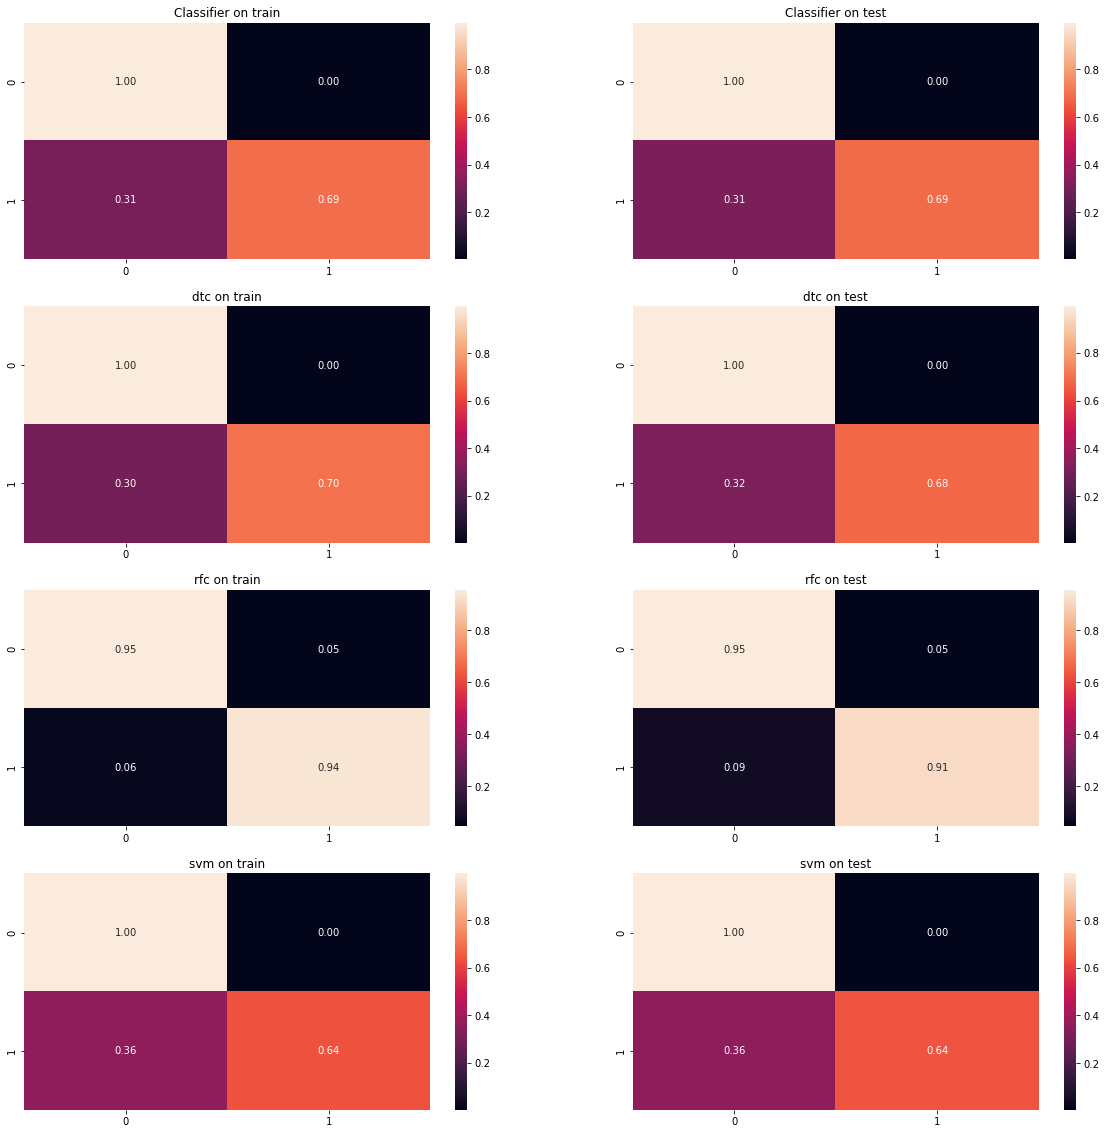

In [55]:
fig, axs = plt.subplots(4, 2, figsize=(20, 20))


cm = confusion_matrix(Y_train, Y_train_pred_grid_logClass, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", ax=axs[0, 0])
axs[0, 0].set_title("Classifier on train")

cm2 = confusion_matrix(Y_test, Y_test_pred_grid_logClass, normalize="true")
sns.heatmap(cm2, annot=True, fmt=".2f", ax=axs[0, 1])
axs[0, 1].set_title("Classifier on test")

cm3 = confusion_matrix(Y_train, Y_train_pred_grid_dtc, normalize="true")
sns.heatmap(cm3, annot=True, fmt=".2f", ax=axs[1, 0])
axs[1, 0].set_title("dtc on train")

cm4 = confusion_matrix(Y_test, Y_test_pred_grid_dtc, normalize="true")
sns.heatmap(cm4, annot=True, fmt=".2f", ax=axs[1, 1])
axs[1, 1].set_title("dtc on test")

cm5 = confusion_matrix(Y_train, Y_train_pred_grid_rfc, normalize="true")
sns.heatmap(cm5, annot=True, fmt=".2f", ax=axs[2, 0])
axs[2, 0].set_title("rfc on train")

cm6 = confusion_matrix(Y_test, Y_test_pred_grid_rfc, normalize="true")
sns.heatmap(cm6, annot=True, fmt=".2f", ax=axs[2, 1])
axs[2, 1].set_title("rfc on test")

cm7 = confusion_matrix(Y_train, Y_train_pred_grid_svm, normalize="true")
sns.heatmap(cm7, annot=True, fmt=".2f", ax=axs[3, 0])
axs[3, 0].set_title("svm on train")

cm8 = confusion_matrix(Y_test, Y_test_pred_grid_svm, normalize="true")
sns.heatmap(cm8, annot=True, fmt=".2f", ax=axs[3, 1])
axs[3, 1].set_title("svm on test")

plt.show()

In [56]:
# Visualize precision recall curves for the best logistic regression
probas_train = grid_logClass.predict_proba(X_train)[:,1]
precisions, recalls, thresholds = precision_recall_curve(Y_train, probas_train)
fig = go.Figure(
    data = go.Scatter(
        name = 'train',
        x = recalls, 
        y = precisions, 
        mode = 'lines'
    ),
    layout = go.Layout(
        title = go.layout.Title(text = "precision_recall_curve for logistic regression", x = 0.5),
        xaxis = go.layout.XAxis(title = 'False Positive Rate'),
        yaxis = go.layout.YAxis(title = 'True Positive Rate')
    )
)

probas_test = grid_logClass.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(Y_test, probas_test)
fig.add_trace(go.Scatter(
    name = 'test',
    x = recalls, 
    y = precisions, 
    mode = 'lines'
    )
)
fig.show()

In [57]:
# Visualize ROC curves for the best Decision Tree classifier
probas_train = grid_dtc.predict_proba(X_train)[:,1]
precisions, recalls, thresholds = precision_recall_curve(Y_train, probas_train)
fig = go.Figure(
    data = go.Scatter(
        name = 'train',
        x = recalls, 
        y = precisions, 
        mode = 'lines'
    ),
    layout = go.Layout(
        title = go.layout.Title(text = "precision_recall_curve for Decision tree classifier", x = 0.5),
        xaxis = go.layout.XAxis(title = 'False Positive Rate'),
        yaxis = go.layout.YAxis(title = 'True Positive Rate')
    )
)

probas_test = grid_dtc.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(Y_test, probas_test)
fig.add_trace(go.Scatter(
    name = 'test',
    x = recalls, 
    y = precisions, 
    mode = 'lines'
    )
)
fig.show()

In [58]:
# Visualize ROC curves for the best random forest classifier
probas_train = grid_rfc.predict_proba(X_train)[:,1]
precisions, recalls, thresholds = precision_recall_curve(Y_train, probas_train)
fig = go.Figure(
    data = go.Scatter(
        name = 'train',
        x = recalls, 
        y = precisions, 
        mode = 'lines'
    ),
    layout = go.Layout(
        title = go.layout.Title(text = "precision_recall_curve for random forest classifier", x = 0.5),
        xaxis = go.layout.XAxis(title = 'False Positive Rate'),
        yaxis = go.layout.YAxis(title = 'True Positive Rate')
    )
)

probas_test = grid_rfc.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(Y_test, probas_test)
fig.add_trace(go.Scatter(
    name = 'test',
    x = recalls, 
    y = precisions, 
    mode = 'lines'
    )
)
fig.show()

Text(0.5, 1.0, 'Precision-Recall curve: AP=0.79')

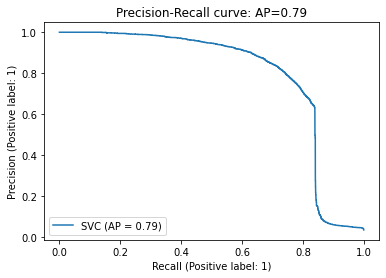

In [59]:
y_train_score = grid_svm.decision_function(X_train)

train_average_precision = average_precision_score(Y_train, y_train_score)

disp = plot_precision_recall_curve(grid_svm, X_train, Y_train)
disp.ax_.set_title('Precision-Recall curve: '
                   'AP={0:0.2f}'.format(train_average_precision))


Text(0.5, 1.0, 'Precision-Recall curve: AP=0.79')

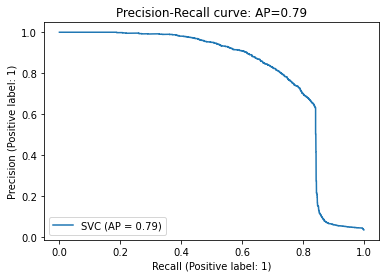

In [60]:
y_test_score = grid_svm.decision_function(X_test)

test_average_precision = average_precision_score(Y_test, y_test_score)

disp = plot_precision_recall_curve(grid_svm, X_test, Y_test)
disp.ax_.set_title('Precision-Recall curve: '
                   'AP={0:0.2f}'.format(test_average_precision))

In [61]:
print(classification_report(Y_train,Y_train_pred_grid_logClass))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    192780
           1       0.86      0.69      0.76      6426

    accuracy                           0.99    199206
   macro avg       0.92      0.84      0.88    199206
weighted avg       0.99      0.99      0.99    199206



In [62]:
print(classification_report(Y_test,Y_test_pred_grid_logClass))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     82620
           1       0.85      0.69      0.76      2754

    accuracy                           0.99     85374
   macro avg       0.92      0.84      0.88     85374
weighted avg       0.99      0.99      0.99     85374



In [63]:
print(classification_report(Y_train,Y_train_pred_grid_dtc))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    192780
           1       0.86      0.70      0.77      6426

    accuracy                           0.99    199206
   macro avg       0.92      0.85      0.88    199206
weighted avg       0.99      0.99      0.99    199206



In [64]:
print(classification_report(Y_test,Y_test_pred_grid_dtc))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     82620
           1       0.82      0.68      0.75      2754

    accuracy                           0.99     85374
   macro avg       0.91      0.84      0.87     85374
weighted avg       0.98      0.99      0.98     85374



In [65]:
print(classification_report(Y_train,Y_train_pred_grid_rfc))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98    192780
           1       0.41      0.94      0.57      6426

    accuracy                           0.95    199206
   macro avg       0.70      0.95      0.77    199206
weighted avg       0.98      0.95      0.96    199206



In [66]:
print(classification_report(Y_test,Y_test_pred_grid_rfc))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     82620
           1       0.40      0.91      0.55      2754

    accuracy                           0.95     85374
   macro avg       0.70      0.93      0.76     85374
weighted avg       0.98      0.95      0.96     85374



In [67]:
print(classification_report(Y_train,Y_train_pred_grid_svm))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    192780
           1       0.89      0.64      0.74      6426

    accuracy                           0.99    199206
   macro avg       0.94      0.82      0.87    199206
weighted avg       0.99      0.99      0.98    199206



In [68]:
print(classification_report(Y_test,Y_test_pred_grid_svm))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     82620
           1       0.88      0.64      0.74      2754

    accuracy                           0.99     85374
   macro avg       0.93      0.82      0.87     85374
weighted avg       0.98      0.99      0.98     85374



## Optimisation with gradient boosting Decision Tree

HalvingGridSearchCV(cv=10, estimator=HistGradientBoostingClassifier(),
                    n_jobs=-1,
                    param_grid={'learning_rate': [0.7, 0.5, 0.3, 0.1],
                                'max_depth': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                'max_iter': array([ 50, 150, 250, 350, 450, 550]),
                                'min_samples_leaf': array([1, 3, 5]),
                                'random_state': [1], 'scoring': ['f1']},
                    refit=<function _refit_callable at 0x7ffd9061e820>,
                    scoring='f1', verbose=1)
n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 819
max_resources_: 199206
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 648
n_resources: 819
Fitting 10 folds for each of 648 candidates, totalling 6480 fits
----------
iter: 1
n_candidates: 216
n_resources: 2457
Fitting 10 folds for each of 216 candidates, totalling 2160 fits
------

/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CPU times: user 19.9 s, sys: 2.69 s, total: 22.6 s
Wall time: 6min 34s
the best set of parameters for the gradient boosting is : 
 {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 150, 'min_samples_leaf': 1, 'random_state': 1, 'scoring': 'f1'}
HistGradientBoostingClassifier(max_depth=5, max_iter=150, min_samples_leaf=1,
                               random_state=1, scoring='f1')
CPU times: user 8.01 s, sys: 1.06 s, total: 9.07 s
Wall time: 1.17 s
HistGradientBoostingClassifier(max_depth=5, max_iter=150, min_samples_leaf=1,
                               random_state=1, scoring='f1')
Predictions on training set with best_gbc model...
...Done.

Predictions on training set with best_gbc model...
...Done.

f1-score on train set for best best_gbc :  0.7674718473308689
f1-score on test set for best best_gbc:  0.7539476314211473

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    192780
           1       0.86      0.69      0.77      6426

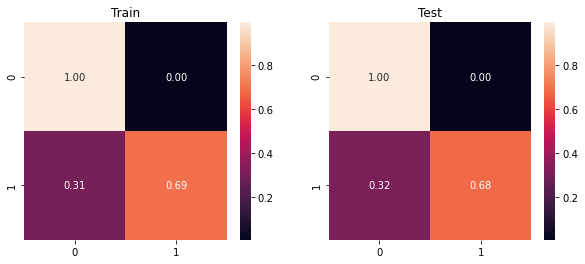

In [69]:
gbc = HistGradientBoostingClassifier()


#learning rate and  ccp_alpha for later ccp_alpha
param_grid_gbc = {"learning_rate": [0.7, 0.5, 0.3, 0.1],
                  "max_iter" : np.arange(50,551,100),
                  "min_samples_leaf": np.arange(1,6,2),
                  "max_depth": np.arange(3,20,2),
                  "scoring":['f1'],
                  "random_state": [1]
                  }

grid_gbc = HalvingGridSearchCV(gbc, param_grid=param_grid_gbc, 
                cv=10, verbose=1, n_jobs=-1, 
                return_train_score=True, scoring='f1')

print(grid_gbc)

%time grid_gbc.fit(X_train, Y_train)

print("the best set of parameters for the gradient boosting is : \n {}".format(grid_gbc.best_params_))

best_gbc = grid_gbc.best_estimator_
print(best_gbc)

%time best_gbc.fit(X_train, Y_train)

# Predictions on training set with best_gbc model
print(best_gbc)
print("Predictions on training set with best_gbc model...")
Y_train_pred = best_gbc.predict(X_train)
print("...Done.")
print()

# Predictions on testing set with best_gbc model
print("Predictions on training set with best_gbc model...")
Y_test_pred = best_gbc.predict(X_test)
print("...Done.")
print()

print("f1-score on train set for best best_gbc : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set for best best_gbc: ", f1_score(Y_test, Y_test_pred))
print()
print(classification_report(Y_train,Y_train_pred))
print(classification_report(Y_test,Y_test_pred))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))

cm_train = confusion_matrix(Y_train, Y_train_pred, normalize="true")
g1 = sns.heatmap(cm_train, annot=True, fmt=".2f",ax=ax1)
g1.set_title("Train")

cm_test = confusion_matrix(Y_test, Y_test_pred, normalize="true")
g2 = sns.heatmap(cm_test, annot=True, fmt=".2f",ax=ax2)
g2.set_title("Test")
plt.show()

## Resample of the imbalanced train sample with SMOTE, SMOTEENN, SMOTETomek and Tomeklinks

In [70]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 206 kB 9.9 MB/s eta 0:00:01


In [71]:
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

HalvingGridSearchCV(cv=10, estimator=HistGradientBoostingClassifier(),
                    n_jobs=-1,
                    param_grid={'learning_rate': [0.7, 0.5, 0.3, 0.1],
                                'max_depth': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                'max_iter': array([ 50, 150, 250, 350, 450, 550]),
                                'min_samples_leaf': array([1, 3, 5]),
                                'random_state': [1], 'scoring': ['f1']},
                    refit=<function _refit_callable at 0x7ffd9061e820>,
                    scoring='f1', verbose=1)
n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 1586
max_resources_: 385560
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 648
n_resources: 1586
Fitting 10 folds for each of 648 candidates, totalling 6480 fits
----------
iter: 1
n_candidates: 216
n_resources: 4758
Fitting 10 folds for each of 216 candidates, totalling 2160 fits
----

/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CPU times: user 1min 5s, sys: 7.49 s, total: 1min 12s
Wall time: 13min 32s
the best set of parameters for this gradient boosting is : 
 {'learning_rate': 0.3, 'max_depth': 5, 'max_iter': 250, 'min_samples_leaf': 1, 'random_state': 1, 'scoring': 'f1'}
CPU times: user 48.5 s, sys: 5.32 s, total: 53.8 s
Wall time: 6.93 s
HistGradientBoostingClassifier(learning_rate=0.3, max_depth=5, max_iter=250,
                               min_samples_leaf=1, random_state=1,
                               scoring='f1')
Predictions on training set with best_hgbc_SMOTE model...
...Done.

Predictions on training set with best_hgbc_SMOTE model...
...Done.

f1-score on train set for best_hgbc_SMOTE :  0.9611717640985934
f1-score on test set for best_hgbc_SMOTE:  0.563768928771733
Train
              precision    recall  f1-score   support

           0       0.97      0.96      0.96    192780
           1       0.96      0.97      0.96    192780

    accuracy                           0.96    385560
   mac

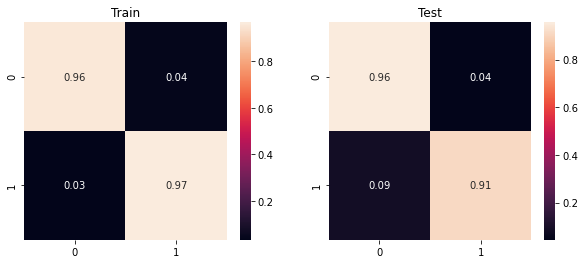

In [72]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, Y_train)

gbc = HistGradientBoostingClassifier()

param_grid_hgbc_SMOTE = {"learning_rate": [0.7, 0.5, 0.3, 0.1],
                                         "max_iter" : np.arange(50,551,100),
                                         "min_samples_leaf": np.arange(1,6,2),
                                         "max_depth": np.arange(3,20,2),
                                          "scoring":['f1'],
                                          "random_state": [1]
                                        }

hgbc_SMOTE = HalvingGridSearchCV(gbc, param_grid=param_grid_hgbc_SMOTE, 
                        cv=10, verbose=1, n_jobs=-1, 
                        return_train_score=True, scoring='f1')
print(hgbc_SMOTE)

%time hgbc_SMOTE.fit(X_smote, y_smote)

print("the best set of parameters for this gradient boosting is : \n {}".format(hgbc_SMOTE.best_params_))                                   
 
best_hgbc_SMOTE = hgbc_SMOTE.best_estimator_    

%time best_hgbc_SMOTE.fit(X_smote, y_smote)

# Predictions on training set with best_hgbc_SMOTE model
print(best_hgbc_SMOTE)
print("Predictions on training set with best_hgbc_SMOTE model...")
Y_train_pred = best_hgbc_SMOTE.predict(X_smote)
print("...Done.")
print()

# Predictions on testing set with best_hgbc_SMOTE model
print("Predictions on training set with best_hgbc_SMOTE model...")
Y_test_pred = best_hgbc_SMOTE.predict(X_test)
print("...Done.")
print()

print("f1-score on train set for best_hgbc_SMOTE : ", f1_score(y_smote, Y_train_pred))
print("f1-score on test set for best_hgbc_SMOTE: ", f1_score(Y_test, Y_test_pred))

print("Train")
print(classification_report(y_smote, Y_train_pred))
print("Test")
print(classification_report(Y_test,Y_test_pred))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))

cm_train = confusion_matrix(y_smote, Y_train_pred, normalize="true")
g1 = sns.heatmap(cm_train, annot=True, fmt=".2f",ax=ax1)
g1.set_title("Train")

cm_test = confusion_matrix(Y_test, Y_test_pred, normalize="true")
g2 = sns.heatmap(cm_test, annot=True, fmt=".2f",ax=ax2)
g2.set_title("Test")
plt.show()

HalvingGridSearchCV(cv=10, estimator=HistGradientBoostingClassifier(),
                    n_jobs=-1,
                    param_grid={'learning_rate': [0.7, 0.5, 0.3, 0.1],
                                'max_depth': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                'max_iter': array([ 50, 150, 250, 350, 450, 550]),
                                'min_samples_leaf': array([1, 3, 5]),
                                'random_state': [1], 'scoring': ['f1']},
                    refit=<function _refit_callable at 0x7ffd9061e820>,
                    scoring='f1', verbose=1)
n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 1467
max_resources_: 356703
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 648
n_resources: 1467
Fitting 10 folds for each of 648 candidates, totalling 6480 fits


/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



----------
iter: 1
n_candidates: 216
n_resources: 4401
Fitting 10 folds for each of 216 candidates, totalling 2160 fits


/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



----------
iter: 2
n_candidates: 72
n_resources: 13203
Fitting 10 folds for each of 72 candidates, totalling 720 fits
----------
iter: 3
n_candidates: 24
n_resources: 39609
Fitting 10 folds for each of 24 candidates, totalling 240 fits
----------
iter: 4
n_candidates: 8
n_resources: 118827
Fitting 10 folds for each of 8 candidates, totalling 80 fits


/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CPU times: user 1min 21s, sys: 8.64 s, total: 1min 30s
Wall time: 12min 48s
the best set of parameters for this gradient boosting is : 
 {'learning_rate': 0.3, 'max_depth': 7, 'max_iter': 350, 'min_samples_leaf': 3, 'random_state': 1, 'scoring': 'f1'}
CPU times: user 1min 5s, sys: 6.17 s, total: 1min 11s
Wall time: 9.13 s
HistGradientBoostingClassifier(learning_rate=0.3, max_depth=7, max_iter=350,
                               min_samples_leaf=3, random_state=1,
                               scoring='f1')
Predictions on training set with best_hgbc_SMOTEENN model...
...Done.

Predictions on training set with best_hgbc_SMOTEENN model...
...Done.

f1-score on train set for best_hgbc_SMOTEENN :  0.9902020079835491
f1-score on test set for best_hgbc_SMOTEENN:  0.5589778690394708
Train
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    181995
           1       1.00      0.98      0.99    174708

    accuracy                           0.99

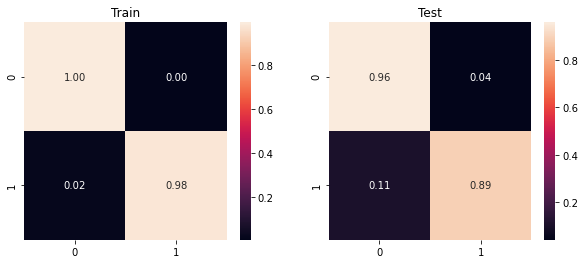

In [73]:
smoteenn = SMOTEENN()
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, Y_train)

gbc = HistGradientBoostingClassifier()

param_grid_hgbc_SMOTEENN = {"learning_rate": [0.7, 0.5, 0.3, 0.1],
                                         "max_iter" : np.arange(50,551,100),
                                         "min_samples_leaf": np.arange(1,6,2),
                                         "max_depth": np.arange(3,20,2),
                                          "scoring":['f1'],
                                          "random_state": [1]
                                        }

hgbc_SMOTEENN = HalvingGridSearchCV(gbc, param_grid=param_grid_hgbc_SMOTEENN, 
                        cv=10, verbose=1, n_jobs=-1, 
                        return_train_score=True, scoring='f1')
print(hgbc_SMOTEENN)

%time hgbc_SMOTEENN.fit(X_smoteenn, y_smoteenn)

print("the best set of parameters for this gradient boosting is : \n {}".format(hgbc_SMOTEENN.best_params_))                                   
 
best_hgbc_SMOTEENN = hgbc_SMOTEENN.best_estimator_    

%time best_hgbc_SMOTEENN.fit(X_smoteenn, y_smoteenn)



# Predictions on training set with best_hgbc_SMOTEENN model
print(best_hgbc_SMOTEENN)
print("Predictions on training set with best_hgbc_SMOTEENN model...")
Y_train_pred = best_hgbc_SMOTEENN.predict(X_smoteenn)
print("...Done.")
print()

# Predictions on testing set with best_hgbc_SMOTEENN model
print("Predictions on training set with best_hgbc_SMOTEENN model...")
Y_test_pred = best_hgbc_SMOTEENN.predict(X_test)
print("...Done.")
print()

print("f1-score on train set for best_hgbc_SMOTEENN : ", f1_score(y_smoteenn, Y_train_pred))
print("f1-score on test set for best_hgbc_SMOTEENN: ", f1_score(Y_test, Y_test_pred))

print("Train")
print(classification_report(y_smoteenn, Y_train_pred))
print("Test")
print(classification_report(Y_test,Y_test_pred))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))

cm_train = confusion_matrix(y_smoteenn, Y_train_pred, normalize="true")
g1 = sns.heatmap(cm_train, annot=True, fmt=".2f",ax=ax1)
g1.set_title("Train")

cm_test = confusion_matrix(Y_test, Y_test_pred, normalize="true")
g2 = sns.heatmap(cm_test, annot=True, fmt=".2f",ax=ax2)
g2.set_title("Test")
plt.show()

HalvingGridSearchCV(cv=10, estimator=HistGradientBoostingClassifier(),
                    n_jobs=-1,
                    param_grid={'learning_rate': [0.7, 0.5, 0.3, 0.1],
                                'max_depth': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                'max_iter': array([ 50, 150, 250, 350, 450, 550]),
                                'min_samples_leaf': array([1, 3, 5]),
                                'random_state': [1], 'scoring': ['f1']},
                    refit=<function _refit_callable at 0x7ffd9061e820>,
                    scoring='f1', verbose=1)
n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 1586
max_resources_: 385482
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 648
n_resources: 1586
Fitting 10 folds for each of 648 candidates, totalling 6480 fits
----------
iter: 1
n_candidates: 216
n_resources: 4758
Fitting 10 folds for each of 216 candidates, totalling 2160 fits
----

/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CPU times: user 1min 23s, sys: 8.91 s, total: 1min 32s
Wall time: 15min 37s
the best set of parameters for this gradient boosting is : 
 {'learning_rate': 0.3, 'max_depth': 7, 'max_iter': 250, 'min_samples_leaf': 3, 'random_state': 1, 'scoring': 'f1'}
CPU times: user 1min 6s, sys: 6.55 s, total: 1min 12s
Wall time: 9.37 s
HistGradientBoostingClassifier(learning_rate=0.3, max_depth=7, max_iter=250,
                               min_samples_leaf=3, random_state=1,
                               scoring='f1')
Predictions on training set with best_hgbc_SMOTETomek model...
...Done.

Predictions on training set with best_hgbc_SMOTETomek model...
...Done.

f1-score on train set for best_hgbc_SMOTETomek :  0.95993809646634
f1-score on test set for best_hgbc_SMOTETomek:  0.5525104143828108
Train
              precision    recall  f1-score   support

           0       0.97      0.95      0.96    192741
           1       0.95      0.97      0.96    192741

    accuracy                         

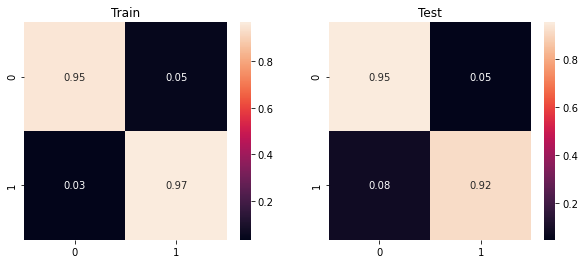

In [74]:
smotetomek = SMOTETomek()
X_smotetomek, y_smotetomek = smotetomek.fit_resample(X_train, Y_train)

gbc = HistGradientBoostingClassifier()

param_grid_hgbc_SMOTETomek = {"learning_rate": [0.7, 0.5, 0.3, 0.1],
                                         "max_iter" : np.arange(50,551,100),
                                         "min_samples_leaf": np.arange(1,6,2),
                                         "max_depth": np.arange(3,20,2),
                                          "scoring":['f1'],
                                          "random_state": [1]
                                        }

hgbc_SMOTETomek = HalvingGridSearchCV(gbc, param_grid=param_grid_hgbc_SMOTETomek, 
                        cv=10, verbose=1, n_jobs=-1, 
                        return_train_score=True, scoring='f1')
print(hgbc_SMOTETomek)

%time hgbc_SMOTETomek.fit(X_smotetomek, y_smotetomek)

print("the best set of parameters for this gradient boosting is : \n {}".format(hgbc_SMOTETomek.best_params_))                                   
 
best_hgbc_SMOTETomek = hgbc_SMOTETomek.best_estimator_    

%time best_hgbc_SMOTETomek.fit(X_smotetomek, y_smotetomek)



# Predictions on training set with best_hgbc_SMOTETomek model
print(best_hgbc_SMOTETomek)
print("Predictions on training set with best_hgbc_SMOTETomek model...")
Y_train_pred = best_hgbc_SMOTETomek.predict(X_smotetomek)
print("...Done.")
print()

# Predictions on testing set with best_hgbc_SMOTETomek model
print("Predictions on training set with best_hgbc_SMOTETomek model...")
Y_test_pred = best_hgbc_SMOTETomek.predict(X_test)
print("...Done.")
print()

print("f1-score on train set for best_hgbc_SMOTETomek : ", f1_score(y_smotetomek, Y_train_pred))
print("f1-score on test set for best_hgbc_SMOTETomek: ", f1_score(Y_test, Y_test_pred))

print("Train")
print(classification_report(y_smotetomek, Y_train_pred))
print("Test")
print(classification_report(Y_test,Y_test_pred))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))

cm_train = confusion_matrix(y_smotetomek, Y_train_pred, normalize="true")
g1 = sns.heatmap(cm_train, annot=True, fmt=".2f",ax=ax1)
g1.set_title("Train")

cm_test = confusion_matrix(Y_test, Y_test_pred, normalize="true")
g2 = sns.heatmap(cm_test, annot=True, fmt=".2f",ax=ax2)
g2.set_title("Test")
plt.show()

HalvingGridSearchCV(cv=10, estimator=HistGradientBoostingClassifier(),
                    n_jobs=-1,
                    param_grid={'learning_rate': [0.7, 0.5, 0.3, 0.1],
                                'max_depth': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                'max_iter': array([ 50, 150, 250, 350, 450, 550]),
                                'min_samples_leaf': array([1, 3, 5]),
                                'random_state': [1], 'scoring': ['f1']},
                    refit=<function _refit_callable at 0x7ffd9061e820>,
                    scoring='f1', verbose=1)
n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 819
max_resources_: 199183
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 648
n_resources: 819
Fitting 10 folds for each of 648 candidates, totalling 6480 fits
----------
iter: 1
n_candidates: 216
n_resources: 2457
Fitting 10 folds for each of 216 candidates, totalling 2160 fits
------

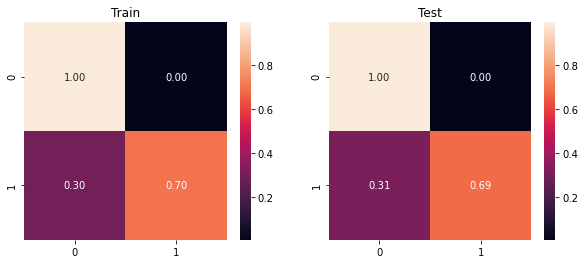

In [75]:
TomekLinks = TomekLinks()
X_TomekLinks, y_TomekLinks = TomekLinks.fit_resample(X_train, Y_train)

gbc = HistGradientBoostingClassifier()

param_grid_hgbc_TomekLinks = {"learning_rate": [0.7, 0.5, 0.3, 0.1],
                                         "max_iter" : np.arange(50,551,100),
                                         "min_samples_leaf": np.arange(1,6,2),
                                         "max_depth": np.arange(3,20,2),
                                          "scoring":['f1'],
                                          "random_state": [1]
                                        }

hgbc_TomekLinks = HalvingGridSearchCV(gbc, param_grid=param_grid_hgbc_TomekLinks, 
                        cv=10, verbose=1, n_jobs=-1, 
                        return_train_score=True, scoring='f1')
print(hgbc_TomekLinks)

%time hgbc_TomekLinks.fit(X_TomekLinks, y_TomekLinks)

print("the best set of parameters for this gradient boosting is : \n {}".format(hgbc_TomekLinks.best_params_))                                   
 
best_hgbc_TomekLinks = hgbc_TomekLinks.best_estimator_    

%time best_hgbc_TomekLinks.fit(X_TomekLinks, y_TomekLinks)



# Predictions on training set with best_hgbc_TomekLinks model
print(best_hgbc_TomekLinks)
print("Predictions on training set with best_hgbc_TomekLinks model...")
Y_train_pred = best_hgbc_TomekLinks.predict(X_TomekLinks)
print("...Done.")
print()

# Predictions on testing set with best_hgbc_TomekLinks model
print("Predictions on training set with best_hgbc_TomekLinks model...")
Y_test_pred = best_hgbc_TomekLinks.predict(X_test)
print("...Done.")
print()

print("f1-score on train set for best_hgbc_TomekLinks : ", f1_score(y_TomekLinks, Y_train_pred))
print("f1-score on test set for best_hgbc_TomekLinks : ", f1_score(Y_test, Y_test_pred))

print("Train")
print(classification_report(y_TomekLinks,Y_train_pred))
print("Test")
print(classification_report(Y_test,Y_test_pred))
      
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))

cm_train = confusion_matrix(y_TomekLinks, Y_train_pred, normalize="true")
g1 = sns.heatmap(cm_train, annot=True, fmt=".2f",ax=ax1)
g1.set_title("Train")

cm_test = confusion_matrix(Y_test, Y_test_pred, normalize="true")
g2 = sns.heatmap(cm_test, annot=True, fmt=".2f",ax=ax2)
g2.set_title("Test")
plt.show()

HalvingGridSearchCV(cv=10, estimator=BalancedRandomForestClassifier(),
                    n_jobs=-1,
                    param_grid={'class_weight': ['balanced_subsample',
                                                 'balanced'],
                                'criterion': ['gini', 'entropy'],
                                'max_depth': array([ 3,  7, 11, 15]),
                                'min_samples_leaf': array([1, 3, 5]),
                                'min_samples_split': array([2, 5, 8]),
                                'n_estimators': array([ 30,  60,  90, 120]),
                                'random_state': [1],
                                'sampling_strategy': [0.8, 0.5, 0.1]},
                    refit=<function _refit_callable at 0x7ffd9061e820>,
                    scoring='f1', verbose=1)
n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 273
max_resources_: 199206
aggressive_elimination: False
factor: 3
----------
iter: 0
n_

/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



----------
iter: 1
n_candidates: 576
n_resources: 819
Fitting 10 folds for each of 576 candidates, totalling 5760 fits
----------
iter: 2
n_candidates: 192
n_resources: 2457
Fitting 10 folds for each of 192 candidates, totalling 1920 fits


/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



----------
iter: 3
n_candidates: 64
n_resources: 7371
Fitting 10 folds for each of 64 candidates, totalling 640 fits


/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



----------
iter: 4
n_candidates: 22
n_resources: 22113
Fitting 10 folds for each of 22 candidates, totalling 220 fits


/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



----------
iter: 5
n_candidates: 8
n_resources: 66339
Fitting 10 folds for each of 8 candidates, totalling 80 fits


/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



----------
iter: 6
n_candidates: 3
n_resources: 199017
Fitting 10 folds for each of 3 candidates, totalling 30 fits


/Users/jd/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CPU times: user 36.7 s, sys: 4.01 s, total: 40.8 s
Wall time: 12min 38s
the best set of parameters for the balanced random forest is : 
 {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 120, 'random_state': 1, 'sampling_strategy': 0.1}
CPU times: user 7.66 s, sys: 46.9 ms, total: 7.71 s
Wall time: 7.71 s
BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               criterion='entropy', max_depth=11,
                               min_samples_leaf=3, min_samples_split=5,
                               n_estimators=120, random_state=1,
                               sampling_strategy=0.1)
Predictions on training set with best_Brfc model...
...Done.

Predictions on training set with best_Brfc model...
...Done.

f1-score on train set for best best_Brfc :  0.5485610695671879
f1-score on test set for best best_Brfc:  0.5377278507842306

              precision    r

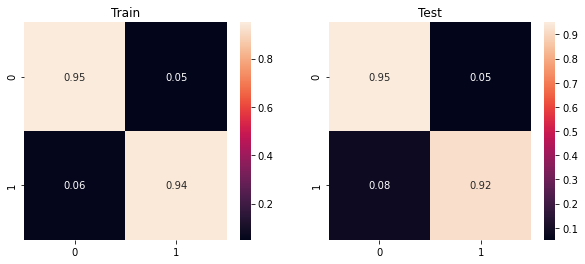

In [76]:
from imblearn.ensemble import BalancedRandomForestClassifier

Brfc = BalancedRandomForestClassifier()


param_grid_Brfc = {"n_estimators": np.arange(30,121,30),
                 "max_depth": np.arange(3,17,4),
                 "criterion" : ["gini", "entropy"],
                 'min_samples_split': np.arange(2,9,3),
                  "min_samples_leaf": np.arange(1,6,2),
                  "class_weight": ["balanced_subsample","balanced"],
                  "sampling_strategy": [0.8, 0.5, 0.1],
                  "random_state": [1]
                  }

grid_Brfc = HalvingGridSearchCV(Brfc, param_grid=param_grid_Brfc, 
                cv=10, verbose=1, n_jobs=-1, 
                return_train_score=True, scoring='f1')

print(grid_Brfc)

%time grid_Brfc.fit(X_train, Y_train)

print("the best set of parameters for the balanced random forest is : \n {}".format(grid_Brfc.best_params_))

best_Brfc = grid_Brfc.best_estimator_

%time best_Brfc.fit(X_train, Y_train)

# Predictions on training set with grid_gbc model
print(best_Brfc)
print("Predictions on training set with best_Brfc model...")
Y_train_pred = best_Brfc.predict(X_train)
print("...Done.")
print()

# Predictions on testing set with grid_gbc model
print("Predictions on training set with best_Brfc model...")
Y_test_pred = best_Brfc.predict(X_test)
print("...Done.")
print()

print("f1-score on train set for best best_Brfc : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set for best best_Brfc: ", f1_score(Y_test, Y_test_pred))
print()
print(classification_report(Y_train,Y_train_pred))
print(classification_report(Y_test,Y_test_pred))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))

cm_train = confusion_matrix(Y_train, Y_train_pred, normalize="true")
g1 = sns.heatmap(cm_train, annot=True, fmt=".2f",ax=ax1)
g1.set_title("Train")

cm_test = confusion_matrix(Y_test, Y_test_pred, normalize="true")
g2 = sns.heatmap(cm_test, annot=True, fmt=".2f",ax=ax2)
g2.set_title("Test")
plt.show()



# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [77]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)


# basic logistic regression
%time classifier.fit(X,Y)
# logistic regression with optimized parameter: C = 10
%time grid_logClass.fit(X,Y)
# basic SVC
%time svm.fit(X,Y)
# Decision Tree with parameters optimized
%time grid_dtc.fit(X,Y)
# Random forest with parameters optimized 
%time grid_rfc.fit(X,Y)
# SVC with parameters optimized
%time grid_svm.fit(X,Y)
# Gradient Boosting with parameters optimized
%time best_gbc.fit(X,Y)
# Gradient Boosting train with SMOTE resampling
X_smote, y_smote = smote.fit_resample(X,Y)
%time best_hgbc_SMOTE.fit(X_smote, y_smote)
# Gradient Boosting train with smoteenn resampling
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X,Y)
%time best_hgbc_SMOTEENN.fit(X_smoteenn, y_smoteenn)
# Gradient Boosting train with smotetomek resampling
X_smotetomek, y_smotetomek = smotetomek.fit_resample(X,Y)
%time  best_hgbc_SMOTETomek.fit(X_smotetomek, y_smotetomek)
# Gradient Boosting train with TomekLinks resampling
X_TomekLinks, y_TomekLinks = TomekLinks.fit_resample(X,Y)
%time best_hgbc_TomekLinks.fit(X_TomekLinks, y_TomekLinks)
# Balanced Randon Forest with parameters optimized 
%time best_Brfc.fit(X,Y)

CPU times: user 372 ms, sys: 904 ms, total: 1.28 s
Wall time: 224 ms
CPU times: user 397 ms, sys: 994 ms, total: 1.39 s
Wall time: 225 ms
CPU times: user 23min 6s, sys: 3.37 s, total: 23min 9s
Wall time: 23min 8s
CPU times: user 129 ms, sys: 389 µs, total: 129 ms
Wall time: 129 ms
CPU times: user 5.62 s, sys: 13.6 ms, total: 5.64 s
Wall time: 5.64 s
CPU times: user 10min 34s, sys: 2.08 s, total: 10min 36s
Wall time: 10min 36s
CPU times: user 16.3 s, sys: 1.82 s, total: 18.1 s
Wall time: 2.44 s
CPU times: user 1min 41s, sys: 9.86 s, total: 1min 51s
Wall time: 14.4 s
CPU times: user 49.9 s, sys: 4.87 s, total: 54.7 s
Wall time: 7.15 s
CPU times: user 45 s, sys: 4.76 s, total: 49.8 s
Wall time: 6.59 s
CPU times: user 12.8 s, sys: 1.48 s, total: 14.2 s
Wall time: 1.94 s
CPU times: user 11.8 s, sys: 305 ms, total: 12.1 s
Wall time: 10.9 s


BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               criterion='entropy', max_depth=11,
                               min_samples_leaf=3, min_samples_split=5,
                               n_estimators=120, random_state=1,
                               sampling_strategy=0.1)

LogisticRegression()
Predictions on training set with basic logistic regression model...
...Done.

f1-score on train set for basic logistic regression :  0.7623469818488814
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    275400
           1       0.85      0.69      0.76      9180

    accuracy                           0.99    284580
   macro avg       0.92      0.84      0.88    284580
weighted avg       0.99      0.99      0.99    284580



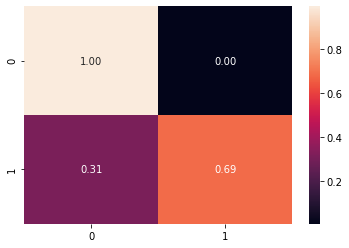

In [78]:
# Predictions on training set with basic logistic regression model
print(classifier)
print("Predictions on training set with basic logistic regression model...")
Y_pred = classifier.predict(X)
print("...Done.")
print()
print("f1-score on train set for basic logistic regression : ", f1_score(Y, Y_pred))
print(classification_report(Y,Y_pred))
cm_train = confusion_matrix(Y, Y_pred, normalize="true")
g = sns.heatmap(cm_train, annot=True, fmt=".2f")

LogisticRegression(C=100.0)
Predictions on training set with logistic regression with optimized parameter model...
...Done.

f1-score on train set for logistic regression with optimized parameter :  0.7626914265042807
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    275400
           1       0.85      0.69      0.76      9180

    accuracy                           0.99    284580
   macro avg       0.92      0.84      0.88    284580
weighted avg       0.99      0.99      0.99    284580



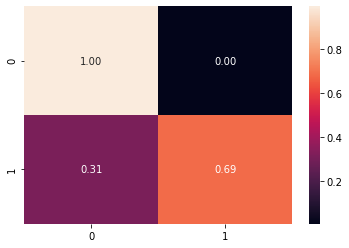

In [79]:
# Predictions on training set with logistic regression with optimized parameter model
print(grid_logClass)
print("Predictions on training set with logistic regression with optimized parameter model...")
Y_pred = grid_logClass.predict(X)
print("...Done.")
print()
print("f1-score on train set for logistic regression with optimized parameter : ", f1_score(Y, Y_pred))
print(classification_report(Y,Y_pred))
cm_train = confusion_matrix(Y, Y_pred, normalize="true")
g = sns.heatmap(cm_train, annot=True, fmt=".2f")

SVC()
Predictions on training set with basic SVC model...
...Done.

f1-score on train set for basic SVC :  0.7533354017995657
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    275400
           1       0.88      0.66      0.75      9180

    accuracy                           0.99    284580
   macro avg       0.93      0.83      0.87    284580
weighted avg       0.99      0.99      0.99    284580



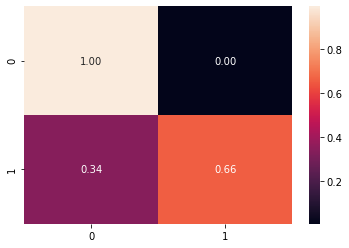

In [80]:
# Predictions on training set with basic SVC model
print(svm)
print("Predictions on training set with basic SVC model...")
Y_pred = svm.predict(X)
print("...Done.")
print()
print("f1-score on train set for basic SVC : ", f1_score(Y, Y_pred))
print(classification_report(Y,Y_pred))
cm_train = confusion_matrix(Y, Y_pred, normalize="true")
g = sns.heatmap(cm_train, annot=True, fmt=".2f")

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=5,
                       min_samples_split=6)
Predictions on training set with Decision Tree with parameters optimized model...
...Done.

f1-score on train set for Decision Tree with parameters optimized :  0.7644985964283582
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    275400
           1       0.85      0.70      0.76      9180

    accuracy                           0.99    284580
   macro avg       0.92      0.85      0.88    284580
weighted avg       0.99      0.99      0.99    284580



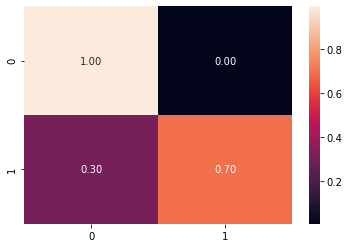

In [81]:
# Predictions on training set with Decision Tree with parameters optimized model
print(grid_dtc)
print("Predictions on training set with Decision Tree with parameters optimized model...")
Y_pred = grid_dtc.predict(X)
print("...Done.")
print()
print("f1-score on train set for Decision Tree with parameters optimized : ", f1_score(Y, Y_pred))
print(classification_report(Y,Y_pred))
cm_train = confusion_matrix(Y, Y_pred, normalize="true")
g = sns.heatmap(cm_train, annot=True, fmt=".2f")

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=11, min_samples_leaf=3)
Predictions on training set with Random forest with parameters optimized  model...
...Done.

f1-score on train set for Random forest with parameters optimized  :  0.5486461606831095
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    275400
           1       0.39      0.94      0.55      9180

    accuracy                           0.95    284580
   macro avg       0.69      0.95      0.76    284580
weighted avg       0.98      0.95      0.96    284580



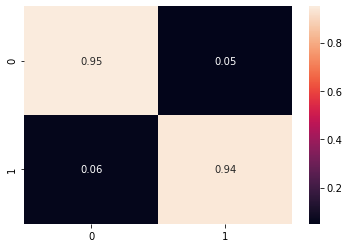

In [82]:
# Predictions on training set with Random forest with parameters optimized  model
print(grid_rfc)
print("Predictions on training set with Random forest with parameters optimized  model...")
Y_pred = grid_rfc.predict(X)
print("...Done.")
print()
print("f1-score on train set for Random forest with parameters optimized  : ", f1_score(Y, Y_pred))
print(classification_report(Y,Y_pred))
cm_train = confusion_matrix(Y, Y_pred, normalize="true")
g = sns.heatmap(cm_train, annot=True, fmt=".2f")

SVC(C=0.0001, gamma=10.0, kernel='poly')
Predictions on training set with SVC with parameters optimized model...
...Done.

f1-score on train set for SVC with parameters optimized :  0.7425742574257425
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    275400
           1       0.89      0.64      0.74      9180

    accuracy                           0.99    284580
   macro avg       0.94      0.82      0.87    284580
weighted avg       0.98      0.99      0.98    284580



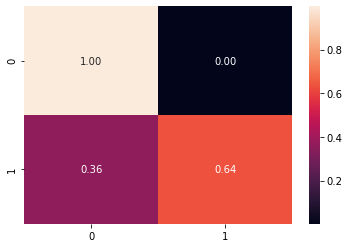

In [83]:
# Predictions on training set with SVC with parameters optimized model
print(grid_svm)
print("Predictions on training set with SVC with parameters optimized model...")
Y_pred = grid_svm.predict(X)
print("...Done.")
print()
print("f1-score on train set for SVC with parameters optimized : ", f1_score(Y, Y_pred))
print(classification_report(Y,Y_pred))
cm_train = confusion_matrix(Y, Y_pred, normalize="true")
g = sns.heatmap(cm_train, annot=True, fmt=".2f")

HistGradientBoostingClassifier(max_depth=5, max_iter=150, min_samples_leaf=1,
                               random_state=1, scoring='f1')
Predictions on training set with Gradient Boosting with parameters optimized model...
...Done.

f1-score on train set for Gradient Boosting with parameters optimized :  0.7637375938029534
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    275400
           1       0.86      0.69      0.76      9180

    accuracy                           0.99    284580
   macro avg       0.92      0.84      0.88    284580
weighted avg       0.99      0.99      0.99    284580



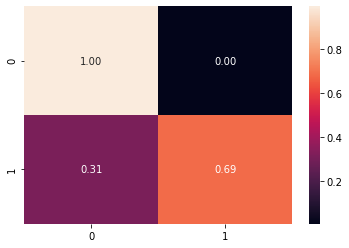

In [84]:
# Predictions on training set with Gradient Boosting with parameters optimized model
print(best_gbc)
print("Predictions on training set with Gradient Boosting with parameters optimized model...")
Y_pred = best_gbc.predict(X)
print("...Done.")
print()
print("f1-score on train set for Gradient Boosting with parameters optimized : ", f1_score(Y, Y_pred))
print(classification_report(Y,Y_pred))
cm_train = confusion_matrix(Y, Y_pred, normalize="true")
g = sns.heatmap(cm_train, annot=True, fmt=".2f")

HistGradientBoostingClassifier(learning_rate=0.3, max_depth=5, max_iter=250,
                               min_samples_leaf=1, random_state=1,
                               scoring='f1')
Predictions on training set with Gradient Boosting train with SMOTE resampling model...
...Done.

f1-score on train set for Gradient Boosting train with SMOTE resampling :  0.9572960236386355
              precision    recall  f1-score   support

           0       0.96      0.95      0.96    275400
           1       0.95      0.96      0.96    275400

    accuracy                           0.96    550800
   macro avg       0.96      0.96      0.96    550800
weighted avg       0.96      0.96      0.96    550800



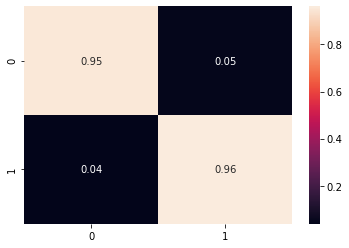

In [85]:
# Predictions on training set with Gradient Boosting train with SMOTE resampling model
print(best_hgbc_SMOTE)
print("Predictions on training set with Gradient Boosting train with SMOTE resampling model...")
Y_pred = best_hgbc_SMOTE.predict(X_smote)
print("...Done.")
print()
print("f1-score on train set for Gradient Boosting train with SMOTE resampling : ", f1_score(y_smote, Y_pred))
print(classification_report(y_smote,Y_pred))
cm_train = confusion_matrix(y_smote, Y_pred, normalize="true")
g = sns.heatmap(cm_train, annot=True, fmt=".2f")

HistGradientBoostingClassifier(learning_rate=0.3, max_depth=7, max_iter=350,
                               min_samples_leaf=3, random_state=1,
                               scoring='f1')
Predictions on training set with Gradient Boosting train with smoteenn resampling model...
...Done.

f1-score on train set for Gradient Boosting train with smoteenn resampling :  0.9904379614941742
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    254353
           1       1.00      0.99      0.99    249535

    accuracy                           0.99    503888
   macro avg       0.99      0.99      0.99    503888
weighted avg       0.99      0.99      0.99    503888



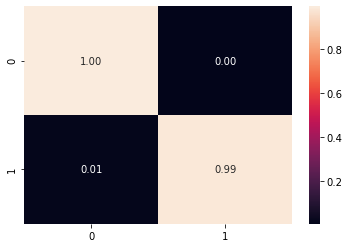

In [86]:
# Predictions on training set with Gradient Boosting train with smoteenn resampling model
print(best_hgbc_SMOTEENN)
print("Predictions on training set with Gradient Boosting train with smoteenn resampling model...")
Y_pred = best_hgbc_SMOTEENN.predict(X_smoteenn)
print("...Done.")
print()
print("f1-score on train set for Gradient Boosting train with smoteenn resampling : ", f1_score(y_smoteenn, Y_pred))
print(classification_report(y_smoteenn,Y_pred))
cm_train = confusion_matrix(y_smoteenn, Y_pred, normalize="true")
g = sns.heatmap(cm_train, annot=True, fmt=".2f")

HistGradientBoostingClassifier(learning_rate=0.3, max_depth=7, max_iter=250,
                               min_samples_leaf=3, random_state=1,
                               scoring='f1')
Predictions on training set with Gradient Boosting train with smotetomek resampling model...
...Done.

f1-score on train set for Gradient Boosting train with smotetomek resampling :  0.9552812973973596
              precision    recall  f1-score   support

           0       0.96      0.95      0.95    275367
           1       0.95      0.96      0.96    275367

    accuracy                           0.96    550734
   macro avg       0.96      0.96      0.96    550734
weighted avg       0.96      0.96      0.96    550734



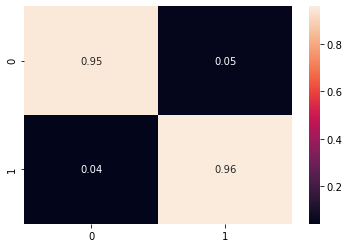

In [87]:
# Predictions on training set with Gradient Boosting train with smotetomek resampling model
print(best_hgbc_SMOTETomek)
print("Predictions on training set with Gradient Boosting train with smotetomek resampling model...")
Y_pred = best_hgbc_SMOTETomek.predict(X_smotetomek)
print("...Done.")
print()
print("f1-score on train set for Gradient Boosting train with smotetomek resampling : ", f1_score(y_smotetomek, Y_pred))
print(classification_report(y_smotetomek,Y_pred))
cm_train = confusion_matrix(y_smotetomek, Y_pred, normalize="true")
g = sns.heatmap(cm_train, annot=True, fmt=".2f")

HistGradientBoostingClassifier(max_depth=11, max_iter=150, min_samples_leaf=3,
                               random_state=1, scoring='f1')
Predictions on training set with Gradient Boosting train with TomekLinks resampling model...
...Done.

f1-score on train set for Gradient Boosting train with TomekLinks resampling :  0.7676102699144174
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    275376
           1       0.85      0.70      0.77      9180

    accuracy                           0.99    284556
   macro avg       0.92      0.85      0.88    284556
weighted avg       0.99      0.99      0.99    284556



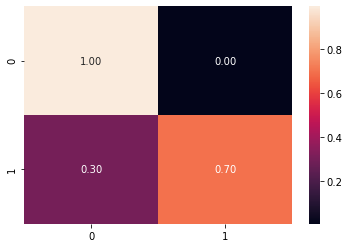

In [88]:
# Predictions on training set with Gradient Boosting train with TomekLinks resampling model
print(best_hgbc_TomekLinks)
print("Predictions on training set with Gradient Boosting train with TomekLinks resampling model...")
Y_pred = best_hgbc_TomekLinks.predict(X_TomekLinks)
print("...Done.")
print()
print("f1-score on train set for Gradient Boosting train with TomekLinks resampling : ", f1_score(y_TomekLinks, Y_pred))
print(classification_report(y_TomekLinks,Y_pred))
cm_train = confusion_matrix(y_TomekLinks, Y_pred, normalize="true")
g = sns.heatmap(cm_train, annot=True, fmt=".2f")

BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               criterion='entropy', max_depth=11,
                               min_samples_leaf=3, min_samples_split=5,
                               n_estimators=120, random_state=1,
                               sampling_strategy=0.1)
Predictions on training set with Balanced Randon Forest with parameters optimized model...
...Done.

f1-score on train set for Balanced Randon Forest with parameters optimized :  0.5394945938366622
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    275400
           1       0.38      0.94      0.54      9180

    accuracy                           0.95    284580
   macro avg       0.69      0.95      0.76    284580
weighted avg       0.98      0.95      0.96    284580



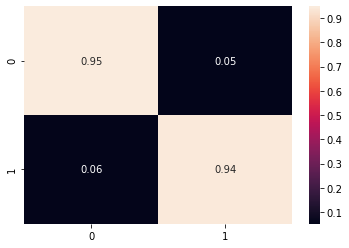

In [89]:
# Predictions on training set with Balanced Random Forest with parameters optimized model
print(best_Brfc)
print("Predictions on training set with Balanced Randon Forest with parameters optimized model...")
Y_pred = best_Brfc.predict(X)
print("...Done.")
print()
print("f1-score on train set for Balanced Randon Forest with parameters optimized : ", f1_score(Y, Y_pred))
print(classification_report(Y,Y_pred))
cm_train = confusion_matrix(Y, Y_pred, normalize="true")
g = sns.heatmap(cm_train, annot=True, fmt=".2f")

In [90]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
X_without_labels_df = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels_df.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[['UK' 28 0 'Seo' 16]
 ['UK' 22 1 'Direct' 5]
 ['China' 32 1 'Seo' 1]
 ['US' 32 1 'Ads' 6]
 ['China' 25 0 'Seo' 3]]


In [91]:
data_without_labels.head()

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


In [92]:
# Basic stats
print("Number of rows : {}".format(X_without_labels_df.shape[0]))
print()

print("Display of dataset: ")
display(X_without_labels_df.head())
print()

print("Basics statistics: ")
data_desc = X_without_labels_df.describe(include='all')
display(X_without_labels_df)
print()

print("Percentage of missing values: ")
display(100*X_without_labels_df.isnull().sum()/X_without_labels_df.shape[0])

Number of rows : 31620

Display of dataset: 


,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3



Basics statistics: 


,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3
...,...,...,...,...,...
31615,Germany,25,1,Seo,3
31616,US,36,1,Ads,7
31617,UK,33,1,Seo,5
31618,UK,25,1,Seo,14



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
dtype: float64

<AxesSubplot:xlabel='country', ylabel='count'>

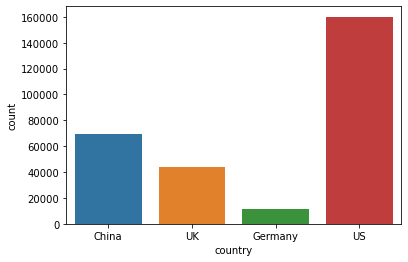

In [93]:
sns.countplot(x=data['country'])

<AxesSubplot:xlabel='country', ylabel='count'>

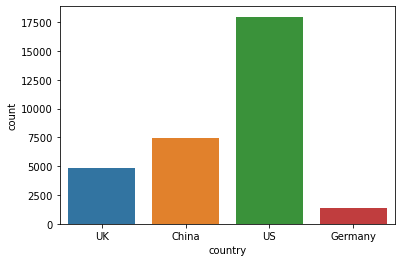

In [94]:
sns.countplot(x=X_without_labels_df['country'])

<AxesSubplot:xlabel='new_user', ylabel='count'>

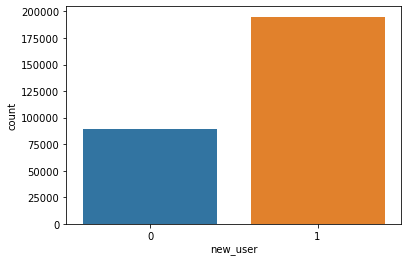

In [95]:
sns.countplot(x=data['new_user'])

<AxesSubplot:xlabel='new_user', ylabel='count'>

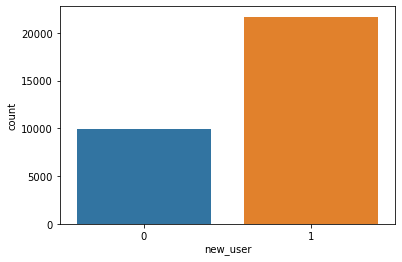

In [96]:
sns.countplot(x=X_without_labels_df['new_user'])

<AxesSubplot:xlabel='source', ylabel='count'>

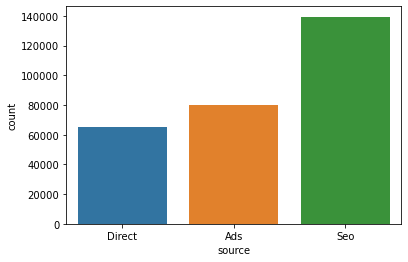

In [97]:
sns.countplot(x=data['source'])

<AxesSubplot:xlabel='source', ylabel='count'>

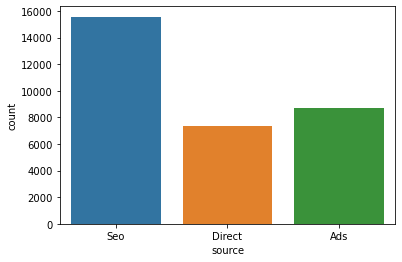

In [98]:
sns.countplot(x=X_without_labels_df['source'])

<AxesSubplot:xlabel='age'>

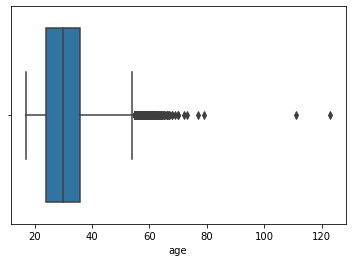

In [99]:
sns.boxplot(x=data["age"])

<AxesSubplot:xlabel='age'>

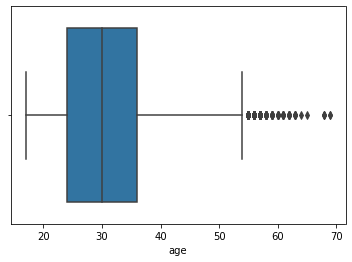

In [100]:
sns.boxplot(x=X_without_labels_df["age"])

<AxesSubplot:xlabel='total_pages_visited'>

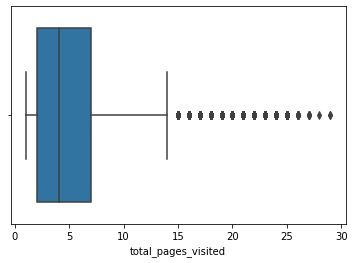

In [101]:
sns.boxplot(x=data["total_pages_visited"])

<AxesSubplot:xlabel='total_pages_visited'>

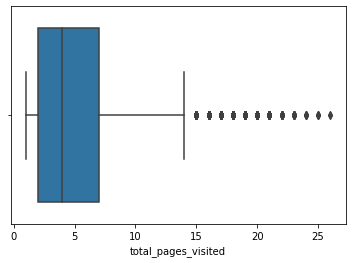

In [102]:
sns.boxplot(x=X_without_labels_df["total_pages_visited"])

In [103]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features, inpute missing values...")
X_without_labels = preprocessor.transform(X_without_labels)
X_without_labels = imputer.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features, inpute missing values...
...Done
[[-0.31198878  3.32962962  0.          1.          0.          0.        ]
 [-1.03710458  0.03697365  0.          1.          0.          1.        ]
 [ 0.17142175 -1.1603558   0.          0.          0.          1.        ]
 [ 0.17142175  0.33630601  0.          0.          1.          1.        ]
 [-0.67454668 -0.56169108  0.          0.          0.          0.        ]]


In [104]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data_final_classifier = {
    'converted': classifier.predict(X_without_labels)
}
data_final_grid_logClass = {
    'converted': grid_logClass.predict(X_without_labels)
}

data_final_svm = {
    'converted': svm.predict(X_without_labels)
}

data_final_grid_dtc = {
    'converted': grid_dtc.predict(X_without_labels)
}

data_final_grid_rfc = {
    'converted': grid_rfc.predict(X_without_labels)
}

data_final_grid_svm = {
    'converted': grid_svm.predict(X_without_labels)
}

data_final_best_gbc = {
    'converted': best_gbc.predict(X_without_labels)
}

data_final_best_hgbc_SMOTE = {
    'converted': best_hgbc_SMOTE.predict(X_without_labels)
}

data_final_best_hgbc_SMOTEENN = {
    'converted': best_hgbc_SMOTEENN.predict(X_without_labels)
}

data_final_best_hgbc_SMOTETomek = {
    'converted': best_hgbc_SMOTETomek.predict(X_without_labels)
}

data_final_best_hgbc_TomekLinks = {
    'converted': best_hgbc_TomekLinks.predict(X_without_labels)
}

data_final_best_Brfc = {
    'converted': best_Brfc.predict(X_without_labels)
}


Y_predictions_1 = pd.DataFrame(columns=['converted'],data=data_final_classifier)
Y_predictions_1.to_csv('conversion_data_test_predictions_JULIEN-model1.csv', index=False)

Y_predictions_2 = pd.DataFrame(columns=['converted'],data=data_final_grid_logClass)
Y_predictions_2.to_csv('conversion_data_test_predictions_JULIEN-model2.csv', index=False)

Y_predictions_3 = pd.DataFrame(columns=['converted'],data=data_final_svm)
Y_predictions_3.to_csv('conversion_data_test_predictions_JULIEN-model3.csv', index=False)

Y_predictions_4 = pd.DataFrame(columns=['converted'],data=data_final_grid_dtc)
Y_predictions_4.to_csv('conversion_data_test_predictions_JULIEN-model4.csv', index=False)

Y_predictions_5 = pd.DataFrame(columns=['converted'],data=data_final_grid_rfc)
Y_predictions_5.to_csv('conversion_data_test_predictions_JULIEN-model5.csv', index=False)

Y_predictions_6 = pd.DataFrame(columns=['converted'],data=data_final_grid_svm)
Y_predictions_6.to_csv('conversion_data_test_predictions_JULIEN-model6.csv', index=False)

Y_predictions_7 = pd.DataFrame(columns=['converted'],data=data_final_best_gbc)
Y_predictions_7.to_csv('conversion_data_test_predictions_JULIEN-model7.csv', index=False)

Y_predictions_8 = pd.DataFrame(columns=['converted'],data=data_final_best_hgbc_SMOTE)
Y_predictions_8.to_csv('conversion_data_test_predictions_JULIEN-model8.csv', index=False)

Y_predictions_9 = pd.DataFrame(columns=['converted'],data=data_final_best_hgbc_SMOTEENN)
Y_predictions_9.to_csv('conversion_data_test_predictions_JULIEN-model9.csv', index=False)

Y_predictions_10 = pd.DataFrame(columns=['converted'],data=data_final_best_hgbc_SMOTETomek)
Y_predictions_10.to_csv('conversion_data_test_predictions_JULIEN-model10.csv', index=False)

Y_predictions_11 = pd.DataFrame(columns=['converted'],data=data_final_best_hgbc_TomekLinks)
Y_predictions_11.to_csv('conversion_data_test_predictions_JULIEN-model11.csv', index=False)

Y_predictions_12 = pd.DataFrame(columns=['converted'],data=data_final_best_Brfc)
Y_predictions_12.to_csv('conversion_data_test_predictions_JULIEN-model12.csv', index=False)

In [105]:
print("the time to completed this program was {}".format((time.time() - start_time)/3600))

the time to completed this program was 2.2804451930522918


## Analyzing the coefficients and interpreting the result
**Here we trained the models and checked the scores. there was no analysis about the feature importance 🤔**

**We'll take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**

In [119]:
# Train model
print("Train LogisticRegression model...")
classifier = LogisticRegression()  
%time classifier.fit(X_train, Y_train)
print("...Done.")

# Predictions on training set with LogisticRegression model
print("Predictions on training set with LogisticRegression model...")
%time Y_train_pred_classifier = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred_classifier)
print()

# Predictions on testing set with LogisticRegression model
print("Predictions on testing set with LogisticRegression model...")
%time Y_test_pred_classifier = classifier.predict(X_test)
print("...Done.")
print()

print("f1-score on train set for LogisticRegression : ", f1_score(Y_train, Y_train_pred_classifier))
print("f1-score on test set for LogisticRegression: ", f1_score(Y_test, Y_test_pred_classifier))

Train LogisticRegression model...
CPU times: user 286 ms, sys: 589 ms, total: 875 ms
Wall time: 185 ms
...Done.
Predictions on training set with LogisticRegression model...
CPU times: user 2.18 ms, sys: 3.79 ms, total: 5.97 ms
Wall time: 1.17 ms
...Done.
[0 0 0 ... 0 0 0]

Predictions on testing set with LogisticRegression model...
CPU times: user 1.42 ms, sys: 3.08 ms, total: 4.5 ms
Wall time: 821 µs
...Done.

f1-score on train set for LogisticRegression :  0.7646602944975459
f1-score on test set for LogisticRegression:  0.7590216519647153


In [120]:
X = data.loc[:, features_list]
pd.DataFrame(zip(X.columns, np.transpose(classifier.coef_.tolist()[0])), columns=['features', 'coef'])

,features,coef
0,country,-0.593317
1,age,2.536036
2,new_user,3.546926
3,source,3.400213
4,total_pages_visited,3.048680


### Conclusion

    As we can see here in the coef analysis,the most important factors are new_user and then the source. Datascienceweekly can concentrate their marketing power on this two factors first, the total_pages_visited is not very usefull even if the coef is high because they can know this only after a customer visit their site(or if they really want to use this feature they have to find a way that the user spend a lot of time on their site, adding a lot of different pages to maximize the number of pages visited by each user (specially the new ones).